In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [4]:
from src.parameters import ANIMALS, SAMPLING_FREQUENCY

epoch_key = ('bon', 3, 2)
use_likelihoods = {
    'lfp_power': ['lfp_power'],
    'spikes': ['spikes'],
    'spikes_and_lfp_power': ['spikes', 'lfp_power']
}

In [91]:
import itertools
from src.load_data import load_data

data_types = set(itertools.chain(*use_likelihoods.values()))
data = load_data(epoch_key, ANIMALS, SAMPLING_FREQUENCY, data_types)

INFO:src.load_data:Loading Data...
/Users/edeno/miniconda3/envs/Replay_ID_2018/lib/python3.6/site-packages/loren_frank_data_processing/tetrodes.py:87: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  for info, animal in tetrode_data
/Users/edeno/miniconda3/envs/Replay_ID_2018/lib/python3.6/site-packages/loren_frank_data_processing/well_traversal_classification.py:151: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  return (pd.DataFrame.from_items(data).set_index(index),


KeyboardInterrupt: 

In [ ]:
from replay_identification import ReplayDetector

position_metric = 'linear_distance'

if data['spikes'] is None:
    s = data['spikes']
else:
    s = data['spikes'].values

if data['multiunit'] is None:
    m = data['multiunit']
else:
    m = data['multiunit'].values

replay_detector = ReplayDetector()
replay_detector.fit(
    data['is_ripple'].values, data['position_info'].speed.values,
    data['position_info'][position_metric].values, data['power'],
    s, m)

In [ ]:
from src.summarize_replay import (add_epoch_info_to_dataframe, compare_overlap,
                                  decode_replays, get_replay_times,
                                  summarize_replays)

likelihoods = ['lfp_power']
name = 'lfp_power'

detector_results = replay_detector.predict(
    data['position_info'].speed.values,
    data['position_info'][position_metric].values, data['power'],
    s, m, time=data['position_info'].index,
    use_likelihoods=likelihoods)

In [ ]:
replay_info, is_replay = get_replay_times(detector_results)
replay_info = add_epoch_info_to_dataframe(replay_info, epoch_key)
decoder_results, replay_decoder = decode_replays(
    data, replay_detector, is_replay, replay_info, SAMPLING_FREQUENCY, position_metric)

In [71]:
replay_info, replay_densities = summarize_replays(
    replay_info, detector_results, decoder_results, data, position_metric)

/Users/edeno/miniconda3/envs/Replay_ID_2018/lib/python3.6/site-packages/replay_classification/decoders.py:464: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return state_probability.loc[is_threshold.argmax()].argmax()
/Users/edeno/miniconda3/envs/Replay_ID_2018/lib/python3.6/site-packages/replay_classification/decoders.py:473: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return state_probability.loc[is_threshold.argmax()].max()
/Users/edeno/miniconda3/envs/Replay_ID_2018/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [65]:
from ipywidgets import interact

number_range = (replay_info.index.min(), replay_info.index.max())

@interact(replay_number=number_range, continuous_update=False)
def plot_replay(replay_number):
    r = (replay_densities
         .sel(replay_number=replay_number)
         .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
         .dropna('time'))
    # Detector
    g = r.detector_posterior.plot(x='time', y='position', robust=True)
    
    COLUMNS = ['replay_type', 'replay_type_confidence',
               'replay_movement_distance', 'replay_motion_type', 'replay_motion_slope',
              'linear_distance']
    info = (replay_info.loc[replay_number, COLUMNS])
    g.axes.axhline(info.linear_distance,
                   color='white', linestyle='--',
                   linewidth=3, alpha=0.8)
    
    g = (r.decoder_posterior
          .plot(x='time', y='position', col='state', col_wrap=2,
                robust=True))
    for ax in g.axes.ravel().tolist():
        ax.axhline(info.linear_distance,
                   color='white', linestyle='--',
                   linewidth=3, alpha=0.8)
    
    display(info)

interactive(children=(IntSlider(value=81, description='replay_number', max=162, min=1), Output()), _dom_classe…

## Save Code

In [71]:
from loren_frank_data_processing import save_xarray
from src.parameters import PROCESSED_DATA_DIR

def save_replay_data(name, epoch_key, replay_info, replay_densities,
                     is_replay):
    save_xarray(PROCESSED_DATA_DIR, epoch_key, replay_densities,
                f'{name}/replay_densities')
    save_xarray(PROCESSED_DATA_DIR, epoch_key,
                replay_info.reset_index().to_xarray(), f'{name}/replay_info')
    save_xarray(PROCESSED_DATA_DIR, epoch_key,
                is_replay.reset_index().to_xarray(), f'{name}/is_replay')

save_replay_data(name, epoch_key, replay_info, replay_densities,
                     is_replay)

In [72]:
def save_ripple_data(epoch_key, data):
    save_xarray(PROCESSED_DATA_DIR, epoch_key,
                data['ripple_labels'].reset_index().to_xarray(),
                '/ripple_labels')
    save_xarray(PROCESSED_DATA_DIR, epoch_key,
                data['ripple_times'].reset_index().to_xarray(),
                '/ripple_times')
    
save_ripple_data(epoch_key, data)

In [73]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='lfp_power/replay_densities')

<xarray.Dataset>
Dimensions:              (position: 187, replay_number: 162, state: 4, time: 640)
Coordinates:
  * time                 (time) timedelta64[ns] 00:00:00 ... 00:00:00.319333
  * position             (position) float64 0.4979 1.494 2.489 ... 184.7 185.7
  * replay_number        (replay_number) int64 1 2 3 4 5 ... 158 159 160 161 162
  * state                (state) object 'Outbound-Forward' ... 'Inbound-Reverse'
Data variables:
    detector_posterior   (replay_number, time, position) float64 ...
    detector_likelihood  (replay_number, time) float64 ...
    decoder_posterior    (replay_number, time, state, position) float64 ...

In [74]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='lfp_power/replay_info').to_dataframe().head()

,replay_number,start_time,end_time,duration,max_probability,track_segment_id,arm_name,labeled_segments,from_well,to_well,...,linear_velocity,linear_speed,linear_position,linear_position2,replay_type,replay_type_confidence,replay_motion_slope,replay_motion_type,replay_movement_distance,credible_interval_size
index,,,,,,,,,,,,,,,,,,,,,
0,1,01:02:22.825700,01:02:22.985033,00:00:00.159333,0.999791,0.0,Center Arm,0.0,,,...,-0.117607,0.117607,NaN,0.007226,Outbound-Reverse,0.999423,23.823095,Neither,0.000000,0.018092
1,2,01:02:27.105700,01:02:27.285033,00:00:00.179333,1.000000,0.0,Center Arm,0.0,,,...,0.070066,0.070066,NaN,4.950396,Outbound-Reverse,0.996762,17.790905,Neither,0.000000,0.018210
2,3,01:02:35.965700,01:02:36.025033,00:00:00.059333,0.821428,0.0,Center Arm,0.0,,,...,0.152085,0.152085,NaN,0.000000,Outbound-Reverse,0.964020,10.755449,Neither,0.000000,0.016335
3,4,01:02:38.145700,01:02:38.245033,00:00:00.099333,0.999719,0.0,Center Arm,0.0,,,...,-0.000982,0.000982,NaN,0.000000,Unclassified,NaN,63.751878,Away,0.000000,0.016686
4,5,01:03:29.205700,01:03:29.327033,00:00:00.121333,0.999992,4.0,Right Arm,0.0,,,...,0.185453,0.185453,NaN,176.714710,Inbound-Forward,0.986575,-1099.419315,Towards,99.321617,0.011563


In [75]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='lfp_power/is_replay').to_dataframe().head()

,time,replay_number,replay_probability
index,,,
0,01:02:09.025700,0,0.0
1,01:02:09.026366,0,0.0
2,01:02:09.027033,0,0.0
3,01:02:09.027700,0,0.0
4,01:02:09.028366,0,0.0


In [76]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='ripple_labels').to_dataframe().head()

,ripple_number
index,
01:02:09.025700,0
01:02:09.026366,0
01:02:09.027033,0
01:02:09.027700,0
01:02:09.028366,0


In [77]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='/ripple_times').to_dataframe().head()

,ripple_number,start_time,end_time
index,,,
0,1,01:02:20.175033,01:02:20.281700
1,2,01:02:22.785700,01:02:22.904366
2,3,01:02:27.075700,01:02:27.181700
3,4,01:02:29.244366,01:02:29.301033
4,5,01:02:34.055033,01:02:34.112366


## Overlap

In [78]:
from ipywidgets import interact

time = data['ripple_labels'].index.total_seconds()
segment_length = 30

@interact(t=(0, time.max()-10, segment_length))
def plot_overlap(t):
    time = data['ripple_labels'].index.total_seconds()
    m = time.min() + t
    is_time = (time > m) & (time < (m + segment_length))

    plt.figure(figsize=(15, 5))
    plt.fill_betweenx(data['ripple_labels'][is_time] > 0, time[is_time], alpha=0.6, label='ripple')
    
    time = is_replay.index.total_seconds()
    m = time.min() + t
    is_time = (time > m) & (time < m + segment_length)
    plt.fill_betweenx((is_replay.replay_number > 0)[is_time], time[is_time], alpha=0.6, label='lfp')

    plt.xlim((m, m + segment_length));
    plt.ylim((0, 1))
    plt.legend();

interactive(children=(FloatSlider(value=2310.0, description='t', max=4650.018366667, step=30.0), Output()), _d…

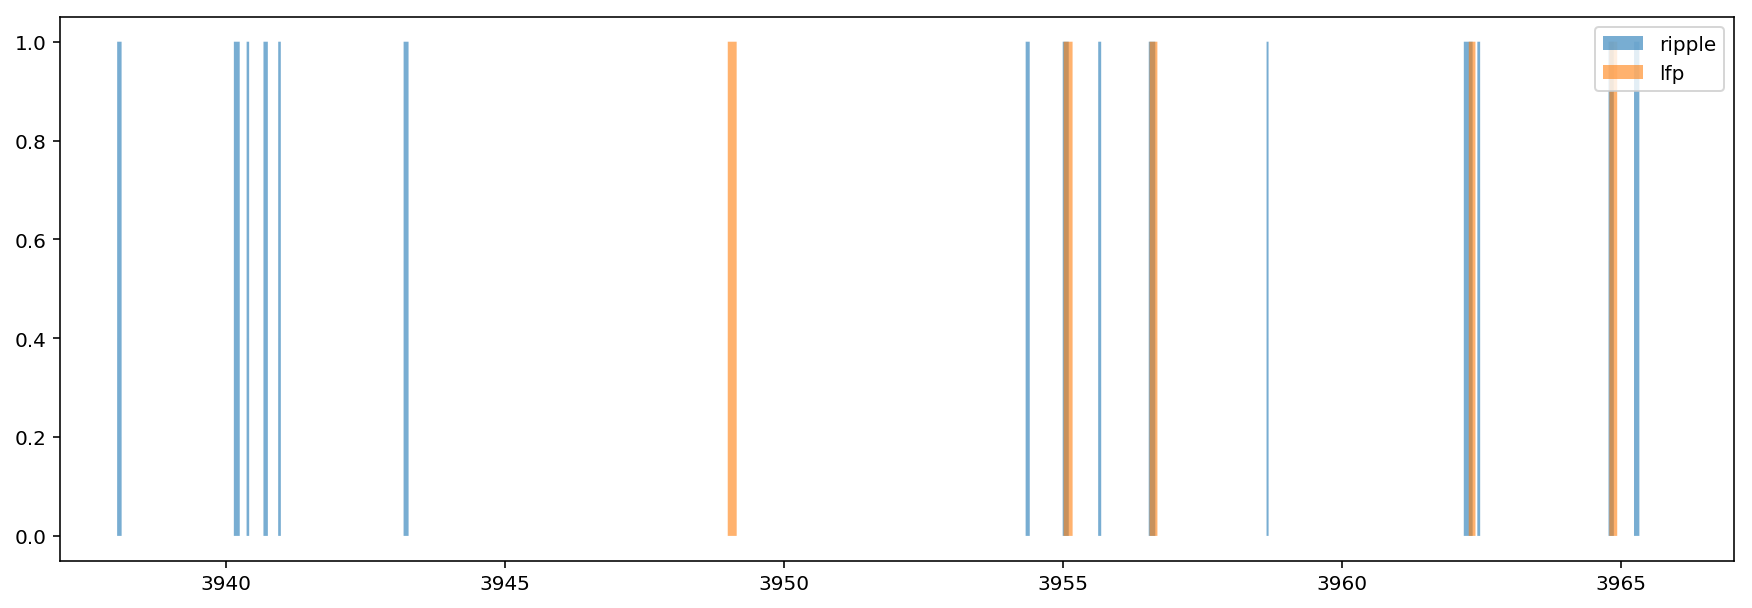

In [432]:
t = 208
segment_length = 30

time = data['ripple_labels'].index.total_seconds()
m = time.min() + t
is_time = (time > m) & (time < (m + segment_length))

plt.figure(figsize=(15, 5))
plt.fill_betweenx(data['ripple_labels'][is_time] > 0, time[is_time], alpha=0.6, label='ripple')

time = is_replay.index.total_seconds()
m = time.min() + t
is_time = (time > m) & (time < m + segment_length)
plt.fill_betweenx((is_replay.replay_number > 0)[is_time], time[is_time], alpha=0.6, label='lfp')

plt.xlim((m, m + segment_length));
plt.legend();

In [350]:
overlap = compare_overlap(data['ripple_labels'], is_replay.replay_number, data['ripple_times'], replay_info)

overlap.head()

,,n_overlap,total_labels1,total_labels2,overlap_percentage1,overlap_percentage2,start_time_difference,end_time_difference
labels1,labels2,,,,,,,
2,1,119,179,240,66.480447,49.583333,-1 days +23:59:59.960000,-1 days +23:59:59.919333
3,2,115,160,270,71.875000,42.592593,-1 days +23:59:59.970000,-1 days +23:59:59.896666
7,3,70,89,90,78.651685,77.777778,-1 days +23:59:59.987333,-1 days +23:59:59.986666
9,4,83,94,150,88.297872,55.333333,-1 days +23:59:59.992666,-1 days +23:59:59.955333
12,5,128,148,186,86.486486,68.817204,-1 days +23:59:59.986666,-1 days +23:59:59.961333


In [351]:
overlap = compare_overlap(is_replay.replay_number, is_replay.replay_number, replay_info, replay_info)

overlap.head()

,,n_overlap,total_labels1,total_labels2,overlap_percentage1,overlap_percentage2,start_time_difference,end_time_difference
labels1,labels2,,,,,,,
1,1,240,240,240,100.0,100.0,0 days,0 days
2,2,270,270,270,100.0,100.0,0 days,0 days
3,3,90,90,90,100.0,100.0,0 days,0 days
4,4,150,150,150,100.0,100.0,0 days,0 days
5,5,186,186,186,100.0,100.0,0 days,0 days


In [609]:
import itertools
from src.summarize_replay import compare_overlap

labels = [is_replay.replay_number, is_replay.replay_number, is_replay.replay_number, is_replay.replay_number]
infos = [replay_info, replay_info, replay_info, replay_info]
names = list(use_likelihoods.keys())
names.append('ripple')

combinations = itertools.combinations(zip(labels, infos, names), 2)
for (labels1, info1, name1), (labels2, info2, name2) in combinations:
    print(name1, name2)
    overlap = compare_overlap(labels1, labels2, info1, info2)


lfp_power spikes
lfp_power spikes_and_lfp_power
lfp_power ripple
spikes spikes_and_lfp_power
spikes ripple
spikes_and_lfp_power ripple


## Position Tuning

In [45]:
from loren_frank_data_processing import get_interpolated_position_dataframe, get_position_dataframe

position_info = get_position_dataframe(
    epoch_key, ANIMALS, route_euclidean_distance_scaling=1, sensor_std_dev=40)

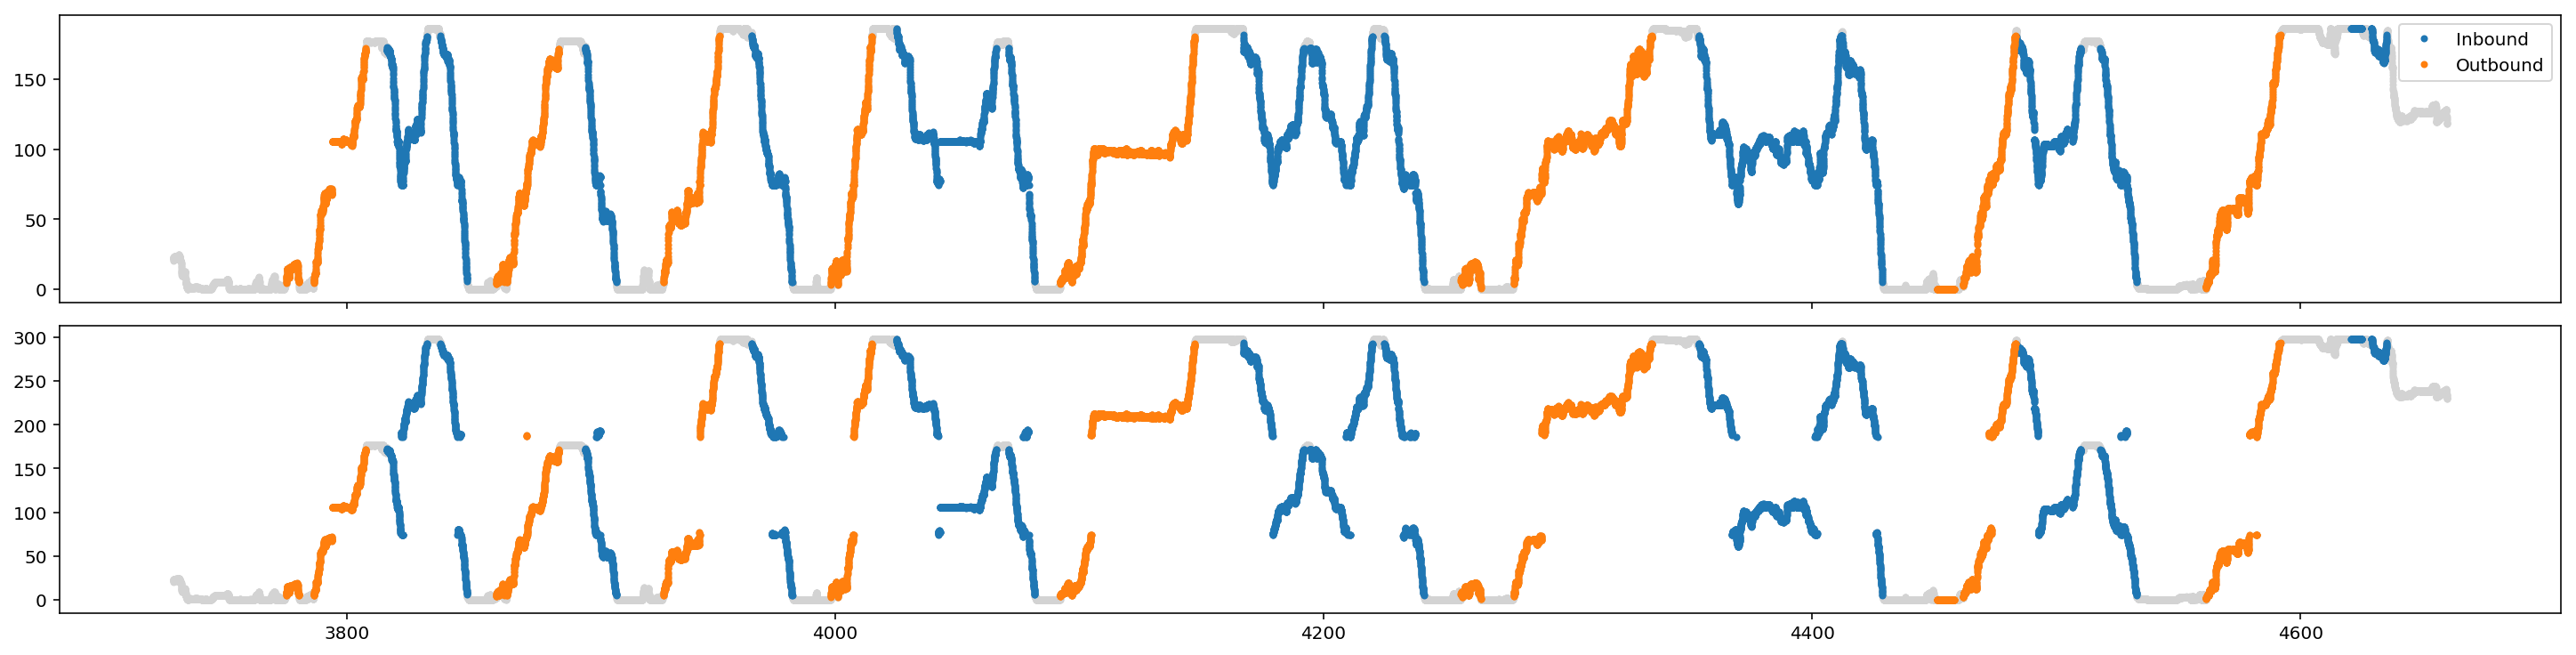

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True, constrained_layout=True)

time = position_info.index.total_seconds()
is_inbound = position_info.task == 'Inbound'
is_outbound = position_info.task == 'Outbound'

axes[0].plot(time, position_info.linear_distance.values, '.', color='lightgrey')
axes[0].plot(time[is_inbound], position_info.linear_distance.values[is_inbound], '.', label='Inbound')
axes[0].plot(time[is_outbound], position_info.linear_distance.values[is_outbound], '.', label='Outbound')

axes[0].legend()

axes[1].plot(time, position_info.linear_position2.values, '.', color='lightgrey')
axes[1].plot(time[is_inbound], position_info.linear_position2.values[is_inbound], '.', label='Inbound')
axes[1].plot(time[is_outbound], position_info.linear_position2.values[is_outbound], '.', label='Outbound')

In [47]:
from scipy.ndimage.measurements import label
from ipywidgets import interact

position_labels = label(position_info.linear_position.fillna(0.0))[0]

@interact(label=(1, position_labels.max()), continuous_update=False)
def plot_position(label):
    position_metric='linear_position2'
    is_label = (position_labels == label)
    colormap = {'Inbound': 'blue',
                'Outbound': 'orange'}
    p = position_info[is_label]
    task = p.task.unique()[0]
    turn = p.turn.unique()[0]
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].plot(position_info.x_position, position_info.y_position, color='lightgrey')
    axes[0].plot(p.x_position, p.y_position, color=colormap[task])
    axes[0].scatter(p.x_position[0], p.y_position[0], color='green', s=100, zorder=1000)
    axes[0].scatter(p.x_position[-1], p.y_position[-1], color='red', s=100, zorder=1000)
    axes[0].set_title(f'{label}: {task} - {turn} turn')
    
    axes[1].plot(p.index.total_seconds(), p[position_metric], color=colormap[task])
    axes[1].scatter(p.index.total_seconds()[0], p[position_metric][0], color='green', s=100, zorder=1000)
    axes[1].scatter(p.index.total_seconds()[-1], p[position_metric][-1], color='red', s=100, zorder=1000)

    axes[1].set_ylim((position_info[position_metric].min(), position_info[position_metric].max()))
    axes[1].set_title('Linear Position')

interactive(children=(IntSlider(value=13, description='label', max=26, min=1), Output()), _dom_classes=('widge…

Text(0.5, 1.0, 'linear_position')

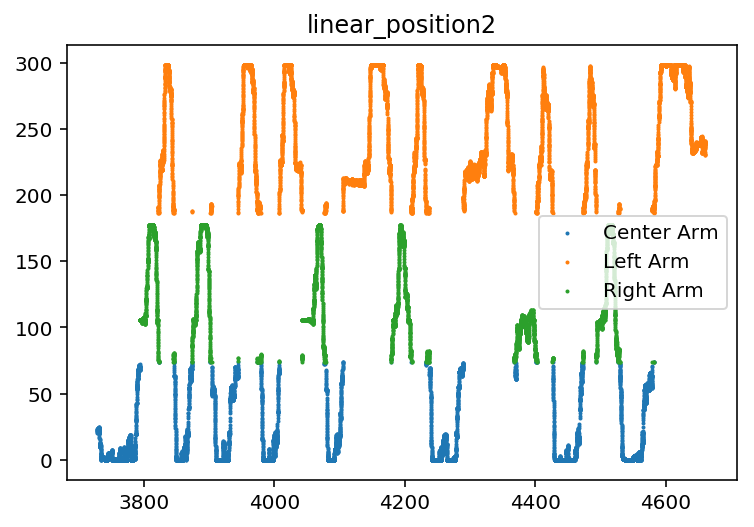

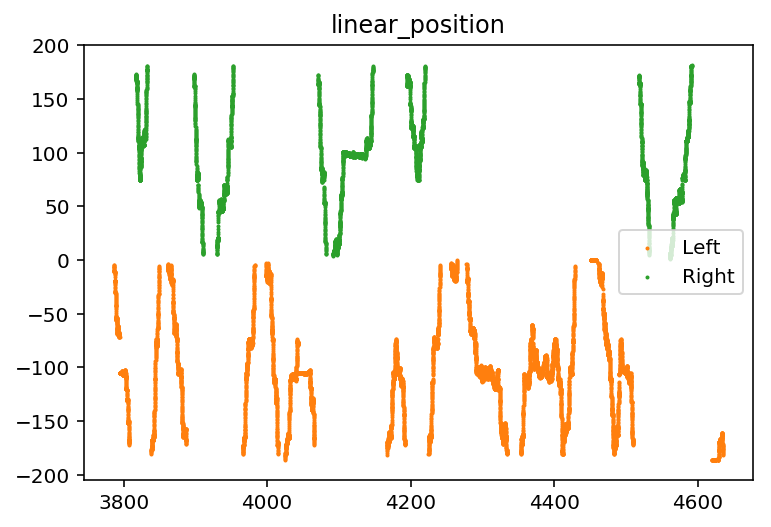

In [325]:
plt.figure()
for name, g in position_info.groupby('arm_name'):
    plt.scatter(g.index.total_seconds(), g.linear_position2, label=name, s=1)
plt.legend()
plt.title('linear_position2')


plt.figure()
for name, g in position_info.groupby('turn'):
    plt.scatter(g.index.total_seconds(), g.linear_position, label=name, s=1)
plt.legend()
plt.title('linear_position')

## Analyze single and double epoch

In [65]:
import itertools
import logging
import sys
from argparse import ArgumentParser
from signal import SIGUSR1, SIGUSR2, signal
from subprocess import PIPE, run

from replay_identification import ReplayDetector
from src.load_data import load_data
from src.parameters import ANIMALS, SAMPLING_FREQUENCY, USE_LIKELIHOODS
from src.save_data import save_overlap, save_replay_data
from src.summarize_replay import (add_epoch_info_to_dataframe, compare_overlap,
                                  decode_replays, get_replay_times,
                                  summarize_replays)


def run_analysis(epoch_key, animals, sampling_frequency, use_likelihoods,
                 position_metric='linear_distance'):
    data_types = set(itertools.chain(*use_likelihoods.values()))
    data = load_data(epoch_key, animals, sampling_frequency, data_types)

    if data['spikes'] is None:
        s = data['spikes']
    else:
        s = data['spikes'].values

    if data['multiunit'] is None:
        m = data['multiunit']
    else:
        m = data['multiunit'].values

    replay_detector = ReplayDetector()
    replay_detector.fit(
        data['is_ripple'].values.squeeze(), data['position_info'].speed.values,
        data['position_info'][position_metric].values, data['power'],
        s, m)

    names = []
    labels = []
    infos = []

    for name, likelihoods in use_likelihoods.items():
        logging.info(f'Finding replays with {name}...')
        if name != 'ripple':
            detector_results = replay_detector.predict(
                data['position_info'].speed.values,
                data['position_info'][position_metric].values, data['power'],
                s, m, time=data['position_info'].index,
                use_likelihoods=likelihoods)
            replay_info, is_replay = get_replay_times(detector_results)
        else:
            replay_info = data['ripple_times'].copy()
            is_replay = data['ripple_labels'].copy()

        logging.info(f'Classifying replays with {name}...')
        replay_info = add_epoch_info_to_dataframe(replay_info, epoch_key, name)
        decoder_results, _ = decode_replays(
            data, replay_detector, is_replay, replay_info, sampling_frequency,
            position_metric)
        logging.info(f'Summarizing replays with {name}...')
        replay_info, replay_densities = summarize_replays(
            replay_info, detector_results, decoder_results, data,
            position_metric)

        # Save Data
        save_replay_data(name, epoch_key, replay_info, replay_densities,
                         is_replay)
        names.append(name)
        labels.append(is_replay.replay_number)
        infos.append(replay_info)

    combination = itertools.combinations(zip(labels, infos, names), 2)
    for (labels1, info1, name1), (labels2, info2, name2) in combination:
        logging.info(
            f'Analyzing replay overlap between {name1} and {name2}...')
        overlap_info = compare_overlap(labels1, labels2, info1, info2)
        overlap_info['animal'] = epoch_key[0]
        overlap_info['day'] = epoch_key[1]
        overlap_info['epoch'] = epoch_key[2]
        save_overlap(overlap_info, epoch_key, name1, name2)
    logging.info('Done...')

In [66]:
epoch_key = ('bon', 3, 2)
run_analysis(epoch_key, ANIMALS, SAMPLING_FREQUENCY, USE_LIKELIHOODS)

INFO:src.load_data:Loading Data...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=3729.0257, n_tapers=1)
INFO:src.load_data:Finding ripple times...
INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


INFO:root:Finding replays with lfp_power...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:root:Classifying replays with lfp_power...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with lfp_power...
INFO:root:Finding replays with spikes...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:root:Classifying replays with spikes...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with spikes...
INFO:root:Finding replays with spikes_and_lfp_power...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:root:Classifying replays with spikes_and_lfp_power...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with spikes_and_lfp_power...
INFO:root:Finding replays with ripple...
INFO:root:Classifying replays with ripple...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with ripple...
INFO:root:Analyzing replay overlap between lfp_power and spikes...
INFO:root:Analyzing replay overlap between lfp_power and spikes_and_lfp_power...
INFO:root:Analyzing replay overlap between lfp_power and ripple...
INFO:root:Analyzing replay overlap between spikes and spikes_and_lfp_power...
INFO:root:Analyzing replay overlap between spikes and ripple...
INFO:root:Analyzing replay overlap between spikes_and_lfp_power and ripple...
INFO:root:Done...


In [67]:
epoch_key = ('bon', 4, 2)
run_analysis(epoch_key, ANIMALS, SAMPLING_FREQUENCY, USE_LIKELIHOODS)

INFO:src.load_data:Loading Data...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=2461.011466666, n_tapers=1)
INFO:src.load_data:Finding ripple times...
INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting movement state transition...


INFO:replay_identification.decoders:Fitting replay state transition...
INFO:root:Finding replays with lfp_power...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:root:Classifying replays with lfp_power...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with lfp_power...
INFO:root:Finding replays with spikes...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:root:Classifying replays with spikes...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with spikes...
INFO:root:Finding replays with spikes_and_lfp_power...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:root:Classifying replays with spikes_and_lfp_power...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with spikes_and_lfp_power...
INFO:root:Finding replays with ripple...
INFO:root:Classifying replays with ripple...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with ripple...
INFO:root:Analyzing replay overlap between lfp_power and spikes...
INFO:root:Analyzing replay overlap between lfp_power and spikes_and_lfp_power...
INFO:root:Analyzing replay overlap between lfp_power and ripple...
INFO:root:Analyzing replay overlap between spikes and spikes_and_lfp_power...
INFO:root:Analyzing replay overlap between spikes and ripple...
INFO:root:Analyzing replay overlap between spikes_and_lfp_power and ripple...
INFO:root:Done...


In [68]:
xr.open_mfdataset('../Processed-Data/*.nc', group='spikes/replay_info',
                  autoclose=True).to_dataframe().head()

,replay_number,start_time,end_time,duration,max_probability,animal,day,epoch,data_source,track_segment_id,...,linear_velocity,linear_speed,linear_position,linear_position2,replay_type,replay_type_confidence,replay_motion_slope,replay_motion_type,replay_movement_distance,credible_interval_size
replay_id,,,,,,,,,,,,,,,,,,,,,
bon_03_02_001_spikes,1,01:02:09.867033,01:02:12.363700,00:00:02.496666,0.982502,bon,3,2,spikes,0.0,...,0.337239,0.337239,NaN,22.390052,Outbound-Forward,0.999865,9.916003,Neither,22.901225,0.014939
bon_03_02_002_spikes,2,01:02:21.865033,01:02:22.121033,00:00:00.256000,0.906101,bon,3,2,spikes,0.0,...,0.092977,0.092977,NaN,0.000000,Outbound-Reverse,0.999858,9.341860,Neither,0.000000,0.018874
bon_03_02_003_spikes,3,01:02:48.183033,01:02:48.480366,00:00:00.297333,0.830940,bon,3,2,spikes,0.0,...,0.529262,0.529262,NaN,0.000000,Outbound-Reverse,1.000000,2.146091,Neither,0.000000,0.018632
bon_03_02_004_spikes,4,01:03:02.912366,01:03:03.162366,00:00:00.250000,0.977562,bon,3,2,spikes,0.0,...,1.291870,1.291870,NaN,0.000000,Outbound-Reverse,0.983779,-367.635879,Towards,103.553365,0.006614
bon_03_02_005_spikes,5,01:03:19.758366,01:03:19.859033,00:00:00.100666,0.853671,bon,3,2,spikes,4.0,...,-0.435518,0.435518,-105.77038,105.770380,Inbound-Forward,0.982398,-1174.392735,Towards,97.579132,0.013180


In [69]:
xr.open_mfdataset('../Processed-Data/*.nc', group='lfp_power/replay_info',
                  autoclose=True).to_dataframe().head()

,replay_number,start_time,end_time,duration,max_probability,animal,day,epoch,data_source,track_segment_id,...,linear_velocity,linear_speed,linear_position,linear_position2,replay_type,replay_type_confidence,replay_motion_slope,replay_motion_type,replay_movement_distance,credible_interval_size
replay_id,,,,,,,,,,,,,,,,,,,,,
bon_03_02_001_lfp_power,1,01:02:22.825700,01:02:22.985033,00:00:00.159333,0.999848,bon,3,2,lfp_power,0.0,...,-0.117607,0.117607,NaN,0.007226,Outbound-Reverse,0.999426,23.823095,Neither,0.000000,0.018092
bon_03_02_002_lfp_power,2,01:02:27.105700,01:02:27.285033,00:00:00.179333,0.999999,bon,3,2,lfp_power,0.0,...,0.070066,0.070066,NaN,4.950396,Outbound-Reverse,0.996774,17.790905,Neither,0.000000,0.018210
bon_03_02_003_lfp_power,3,01:02:35.965700,01:02:36.025033,00:00:00.059333,0.806958,bon,3,2,lfp_power,0.0,...,0.152085,0.152085,NaN,0.000000,Outbound-Reverse,0.964005,10.755449,Neither,0.000000,0.016334
bon_03_02_004_lfp_power,4,01:02:38.145700,01:02:38.245033,00:00:00.099333,0.999656,bon,3,2,lfp_power,0.0,...,-0.000982,0.000982,NaN,0.000000,Unclassified,NaN,64.315383,Away,0.000000,0.016685
bon_03_02_005_lfp_power,5,01:03:29.205700,01:03:29.331033,00:00:00.125333,0.999992,bon,3,2,lfp_power,4.0,...,0.185453,0.185453,NaN,176.714710,Inbound-Forward,0.985830,-1059.634683,Towards,96.583427,0.011474


In [70]:
xr.open_mfdataset('../Processed-Data/*.nc', group='spikes_and_lfp_power/replay_info',
                 autoclose=True).to_dataframe().head()

,replay_number,start_time,end_time,duration,max_probability,animal,day,epoch,data_source,track_segment_id,...,linear_velocity,linear_speed,linear_position,linear_position2,replay_type,replay_type_confidence,replay_motion_slope,replay_motion_type,replay_movement_distance,credible_interval_size
replay_id,,,,,,,,,,,,,,,,,,,,,
bon_03_02_001_spikes_and_lfp_power,1,01:02:22.825700,01:02:22.985033,00:00:00.159333,0.999922,bon,3,2,spikes_and_lfp_power,0.0,...,-0.117607,0.117607,NaN,0.007226,Outbound-Reverse,0.999530,22.960549,Neither,0.0,0.018089
bon_03_02_002_spikes_and_lfp_power,2,01:02:27.105700,01:02:27.265033,00:00:00.159333,0.999999,bon,3,2,spikes_and_lfp_power,0.0,...,0.070066,0.070066,NaN,4.950396,Outbound-Reverse,0.986248,21.372446,Neither,0.0,0.017830
bon_03_02_003_spikes_and_lfp_power,3,01:02:35.965700,01:02:36.045033,00:00:00.079333,0.994183,bon,3,2,spikes_and_lfp_power,0.0,...,0.152085,0.152085,NaN,0.000000,Outbound-Reverse,0.990773,101.066726,Away,0.0,0.016726
bon_03_02_004_spikes_and_lfp_power,4,01:02:38.145700,01:02:38.245033,00:00:00.099333,0.996901,bon,3,2,spikes_and_lfp_power,0.0,...,-0.000982,0.000982,NaN,0.000000,Unclassified,NaN,63.155864,Away,0.0,0.016698
bon_03_02_005_spikes_and_lfp_power,5,01:03:19.745700,01:03:19.837033,00:00:00.091333,0.996893,bon,3,2,spikes_and_lfp_power,4.0,...,-0.437398,0.437398,-106.090617,106.090617,Unclassified,NaN,1.362355,Neither,0.0,0.016532


In [74]:
xr.open_mfdataset('../Processed-Data/*.nc', group='overlap/spikes/ripple',
                  autoclose=True).to_dataframe()

,replay_number1,replay_numbers2,n_overlap,total_labels1,total_labels2,overlap_percentage1,overlap_percentage2,start_time_difference,end_time_difference,animal,day,epoch
index,,,,,,,,,,,,
0,bon_03_02_006_spikes,bon_03_02_012_ripple,87,348,148,25.000000,58.783784,0.040667,0.174000,bon,3,2
1,bon_03_02_007_spikes,bon_03_02_014_ripple,91,344,115,26.453488,79.130435,0.016000,0.168667,bon,3,2
2,bon_03_02_008_spikes,bon_03_02_015_ripple,75,265,148,28.301887,50.675676,0.048667,0.126667,bon,3,2
3,bon_03_02_009_spikes,bon_03_02_016_ripple,168,276,203,60.869565,82.758621,0.023333,0.072000,bon,3,2
4,bon_03_02_010_spikes,bon_03_02_017_ripple,81,265,164,30.566038,49.390244,0.055333,0.122667,bon,3,2
5,bon_03_02_012_spikes,bon_03_02_022_ripple,79,239,98,33.054393,80.612245,0.012667,0.106667,bon,3,2
6,bon_03_02_013_spikes,bon_03_02_023_ripple,56,341,107,16.422287,52.336449,0.034000,0.190000,bon,3,2
7,bon_03_02_014_spikes,bon_03_02_024_ripple,143,457,143,31.291028,100.000000,-0.184667,0.024667,bon,3,2
8,bon_03_02_015_spikes,bon_03_02_025_ripple,66,438,247,15.068493,26.720648,-0.248000,-0.120667,bon,3,2


In [75]:
xr.open_mfdataset('../Processed-Data/*.nc', group='lfp_power/replay_densities',
                  autoclose=True, concat_dim='replay_id')

<xarray.Dataset>
Dimensions:              (position: 360, replay_id: 249, state: 4, time: 1003)
Coordinates:
  * position             (position) float64 0.4979 0.498 1.494 ... 184.7 185.7
  * time                 (time) timedelta64[ns] 00:00:00 ... 00:00:00.458666
  * state                (state) object 'Outbound-Forward' ... 'Inbound-Reverse'
  * replay_id            (replay_id) object 'bon_03_02_001_lfp_power' ... 'bon_04_02_085_lfp_power'
Data variables:
    detector_posterior   (replay_id, time, position) float64 dask.array<shape=(249, 1003, 360), chunksize=(164, 1003, 360)>
    detector_likelihood  (replay_id, time) float64 dask.array<shape=(249, 1003), chunksize=(164, 1003)>
    decoder_posterior    (replay_id, time, state, position) float64 dask.array<shape=(249, 1003, 4, 360), chunksize=(164, 1003, 4, 360)>

In [3]:
import itertools
import sys
from os.path import join

import xarray as xr

from src.parameters import PROCESSED_DATA_DIR, USE_LIKELIHOODS

filenames = join(PROCESSED_DATA_DIR, '*.nc')

COLUMNS = ['animal', 'day', 'epoch',
           'replay_type', 'replay_motion_type', 'replay_movement_distance',
           'credible_interval_size', 'data_source', 'duration']

replay_info = pd.concat(
    [xr.open_mfdataset(
        filenames, group=f'{name}/replay_info', autoclose=True
        ).to_dataframe().loc[:, COLUMNS]
     for name in USE_LIKELIHOODS])

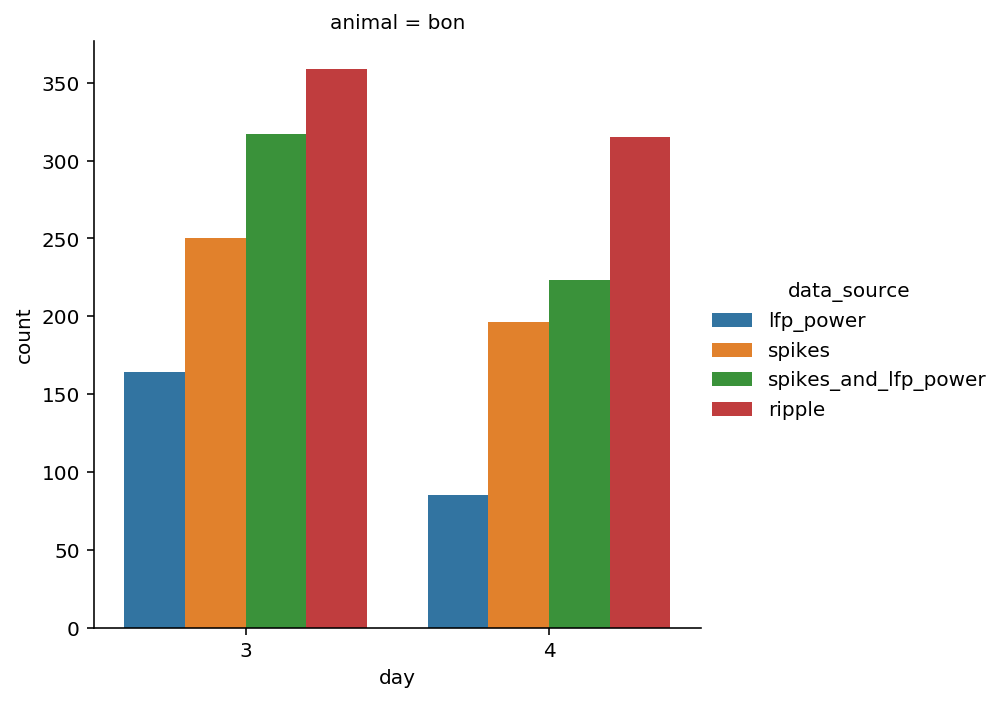

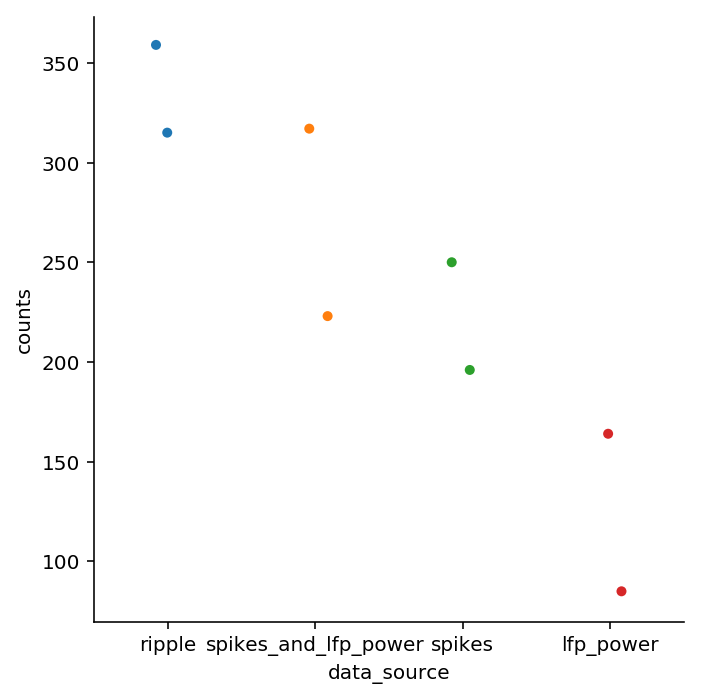

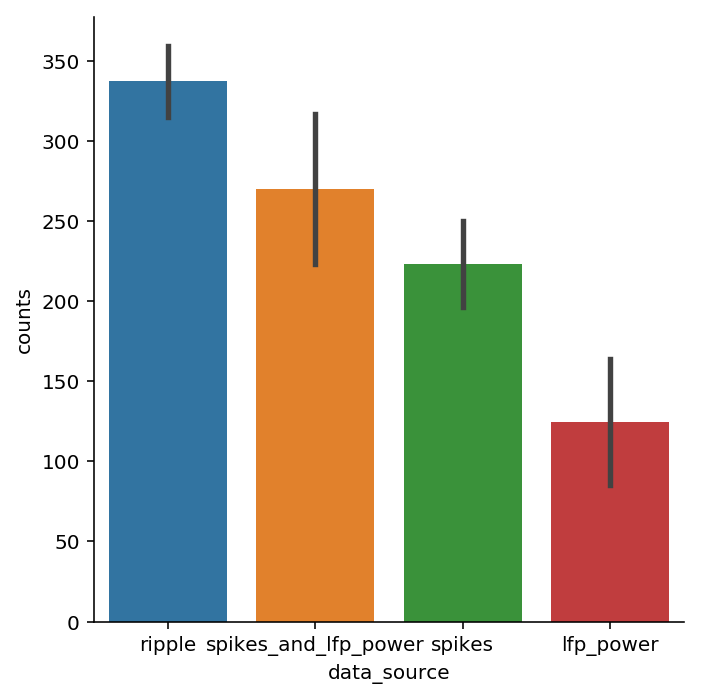

In [236]:
import seaborn as sns
# Compare number of events
sns.catplot(x='day', data=replay_info, kind='count', hue='data_source', col='animal')


# Compare number of events per day
df = (replay_info['data_source']
      .groupby(replay_info['day'])
      .value_counts()
      .rename('counts')
      .reset_index()
     )
sns.catplot(x='data_source', y='counts', data=df)
sns.catplot(x='data_source', y='counts', data=df, kind='bar')

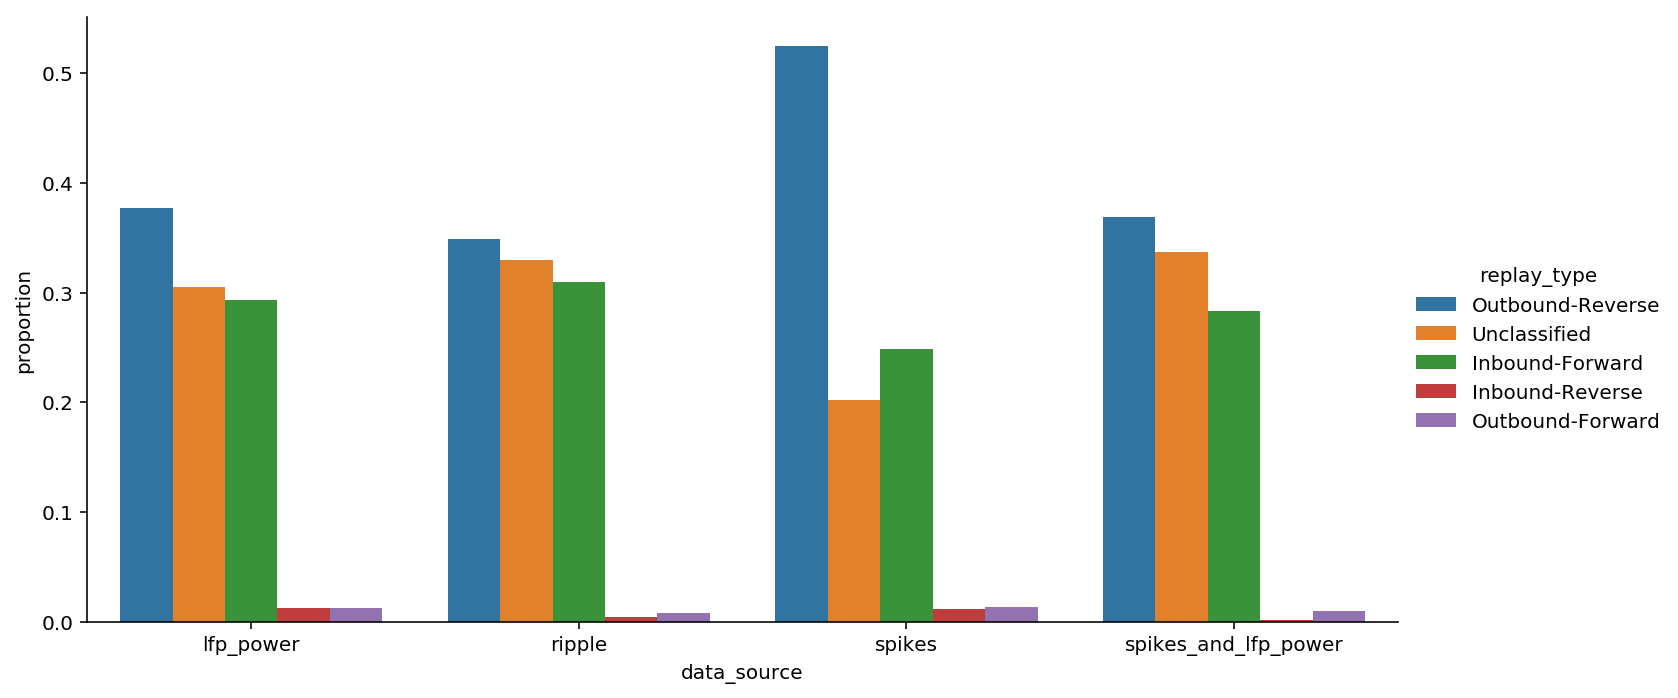

In [224]:
# Compare replay types count (inbound vs. outbound, forward vs. reverse)

# sns.catplot(x='data_source', data=replay_info, kind='count', hue='replay_type', col='animal', aspect=2)

prop_df = (replay_info['replay_type']
           .groupby(replay_info['data_source'])
           .value_counts(normalize=True)
           .rename('proportion')
           .reset_index())

sns.catplot(x='data_source', y='proportion', hue='replay_type', data=prop_df, kind='bar', aspect=2)

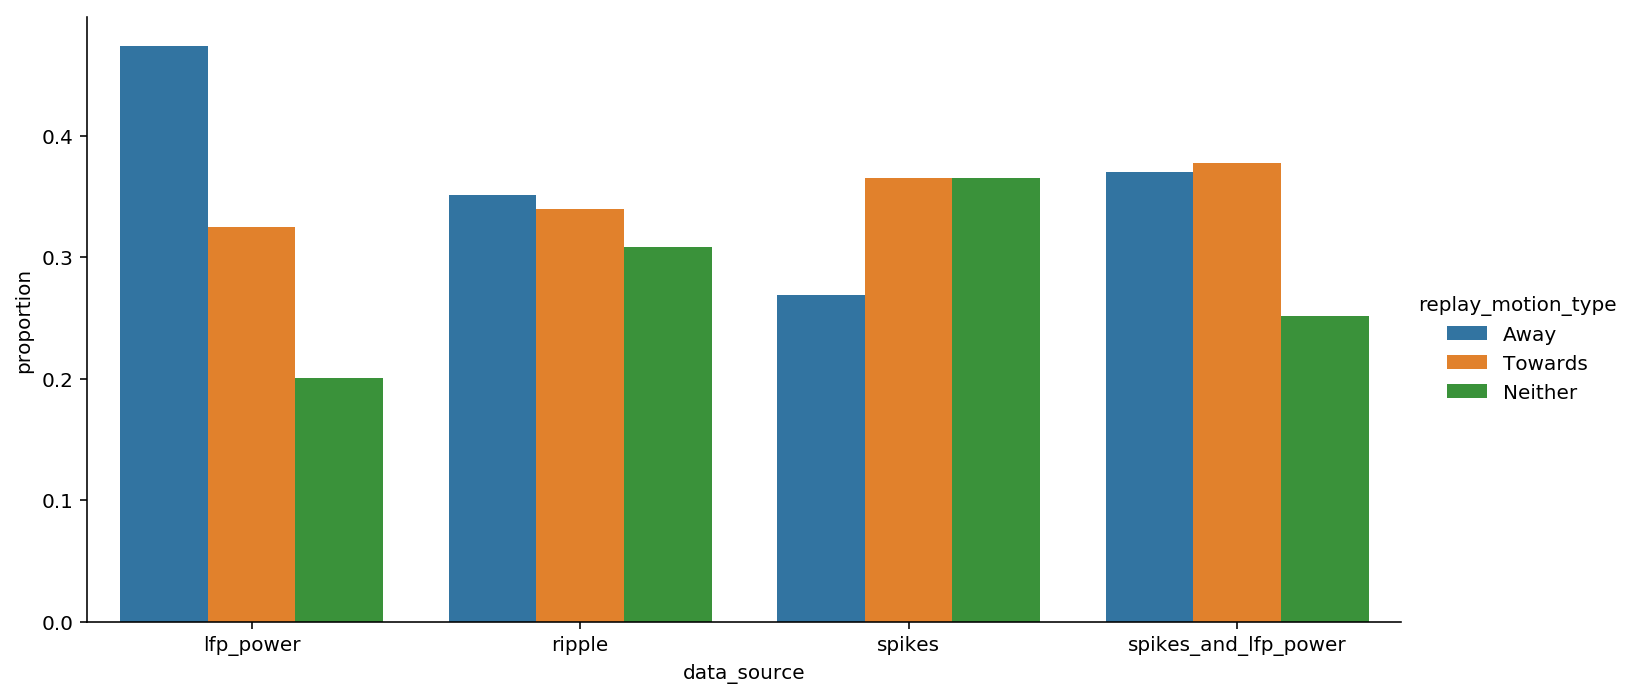

In [223]:
# Compare replay motion count (towards vs. away animal position)
# sns.catplot(x='data_source', data=replay_info, kind='count', hue='replay_motion_type', col='animal', aspect=2)

prop_df = (replay_info['replay_motion_type']
           .groupby(replay_info['data_source'])
           .value_counts(normalize=True)
           .rename('proportion')
           .reset_index())

sns.catplot(x='data_source', y='proportion', hue='replay_motion_type', data=prop_df, kind='bar', aspect=2)

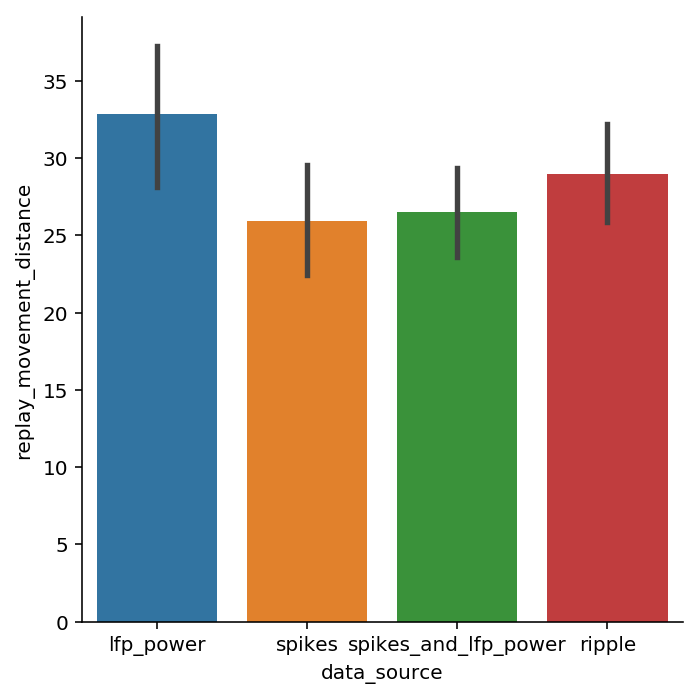

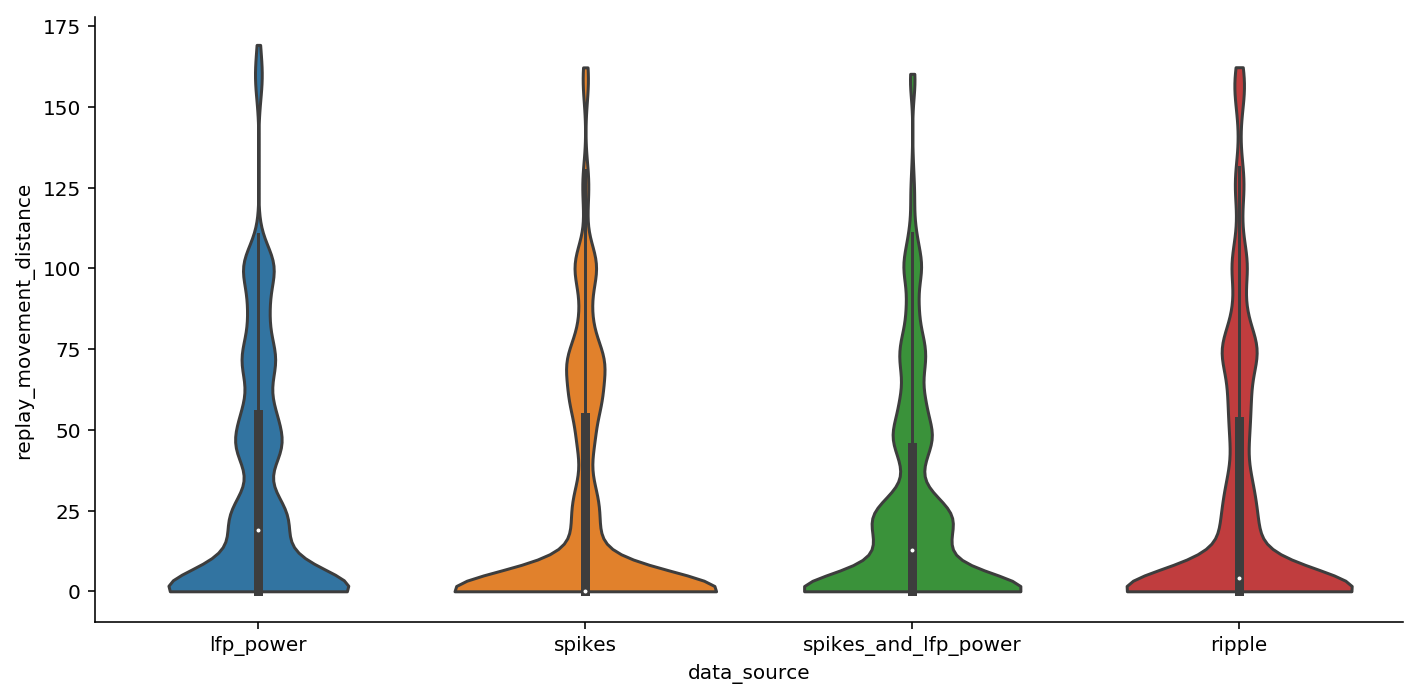

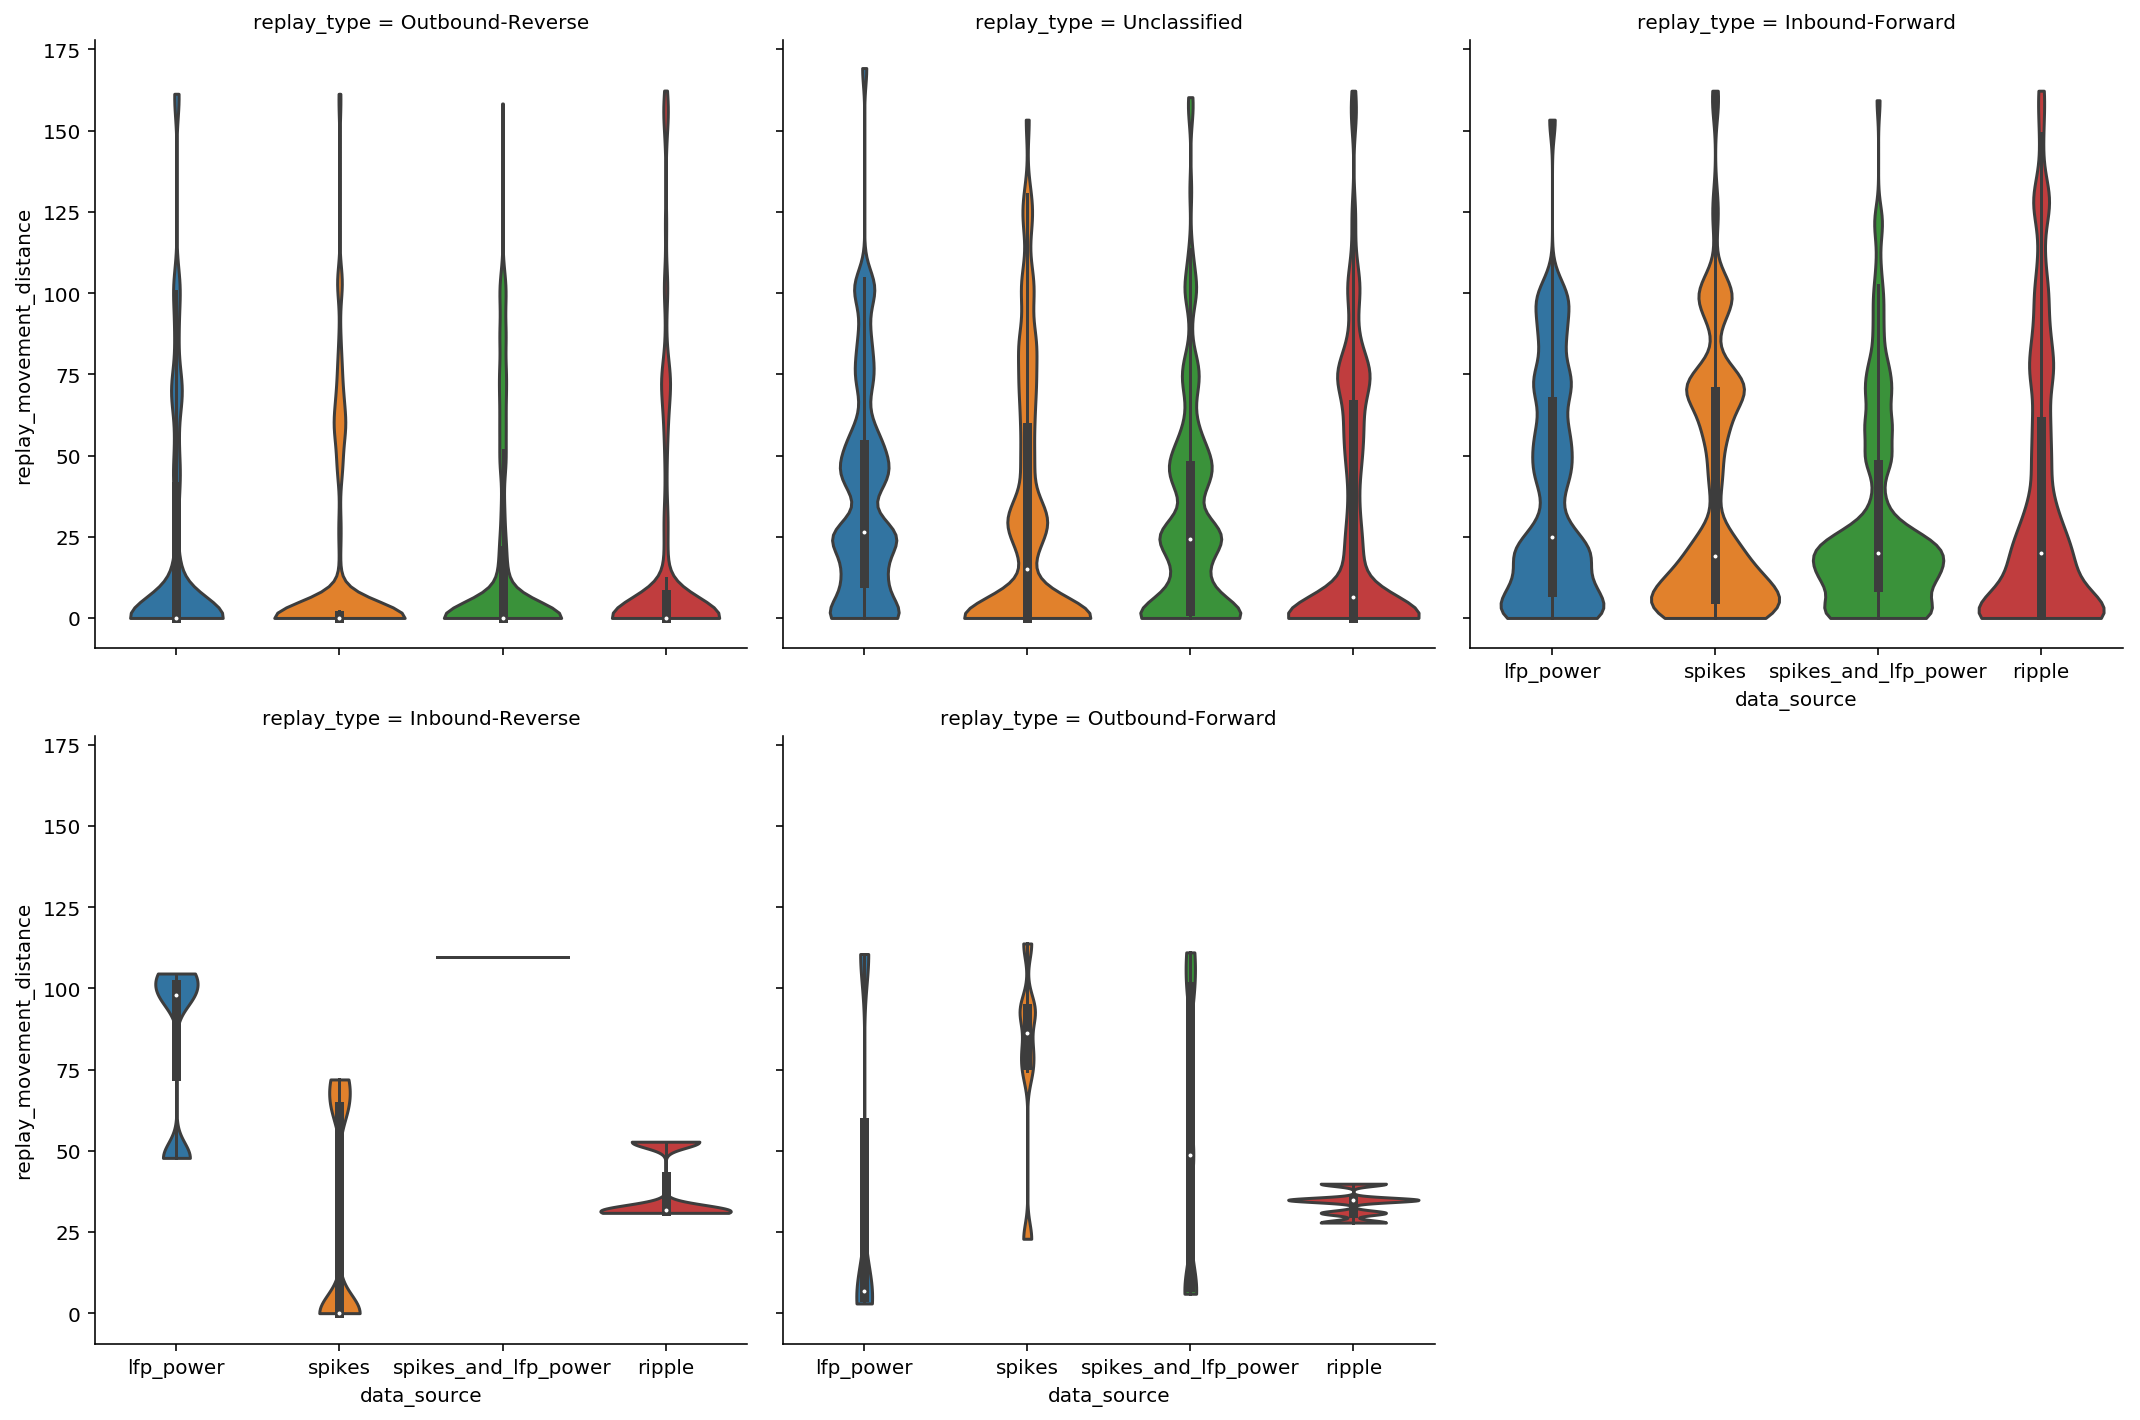

In [201]:
# Compare how far the replay position moves.
sns.catplot(x='data_source', y='replay_movement_distance', data=replay_info, aspect=1,
            kind='bar')
sns.catplot(x='data_source', y='replay_movement_distance', data=replay_info, aspect=2,
            kind='violin', bw=.15, cut=0)
sns.catplot(x='data_source', y='replay_movement_distance', data=replay_info, aspect=1,
            kind='violin', bw=.15, cut=0, col='replay_type', col_wrap=3)

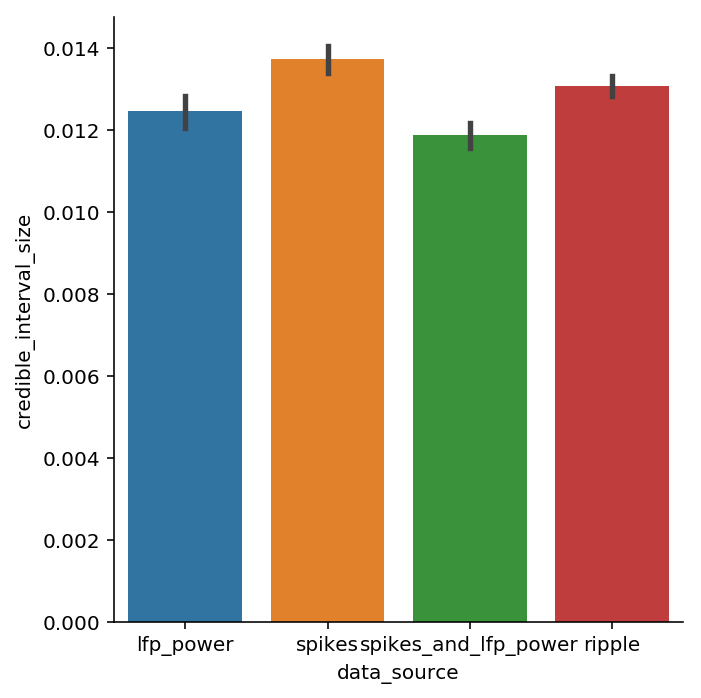

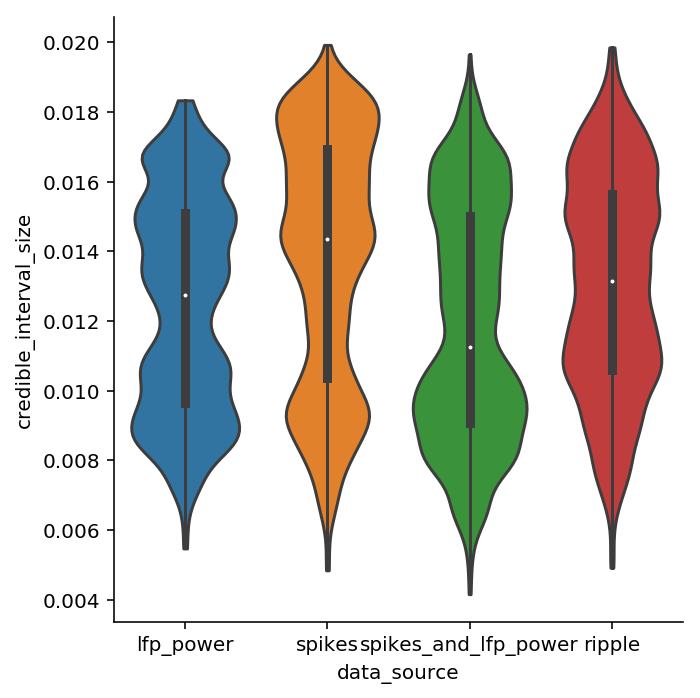

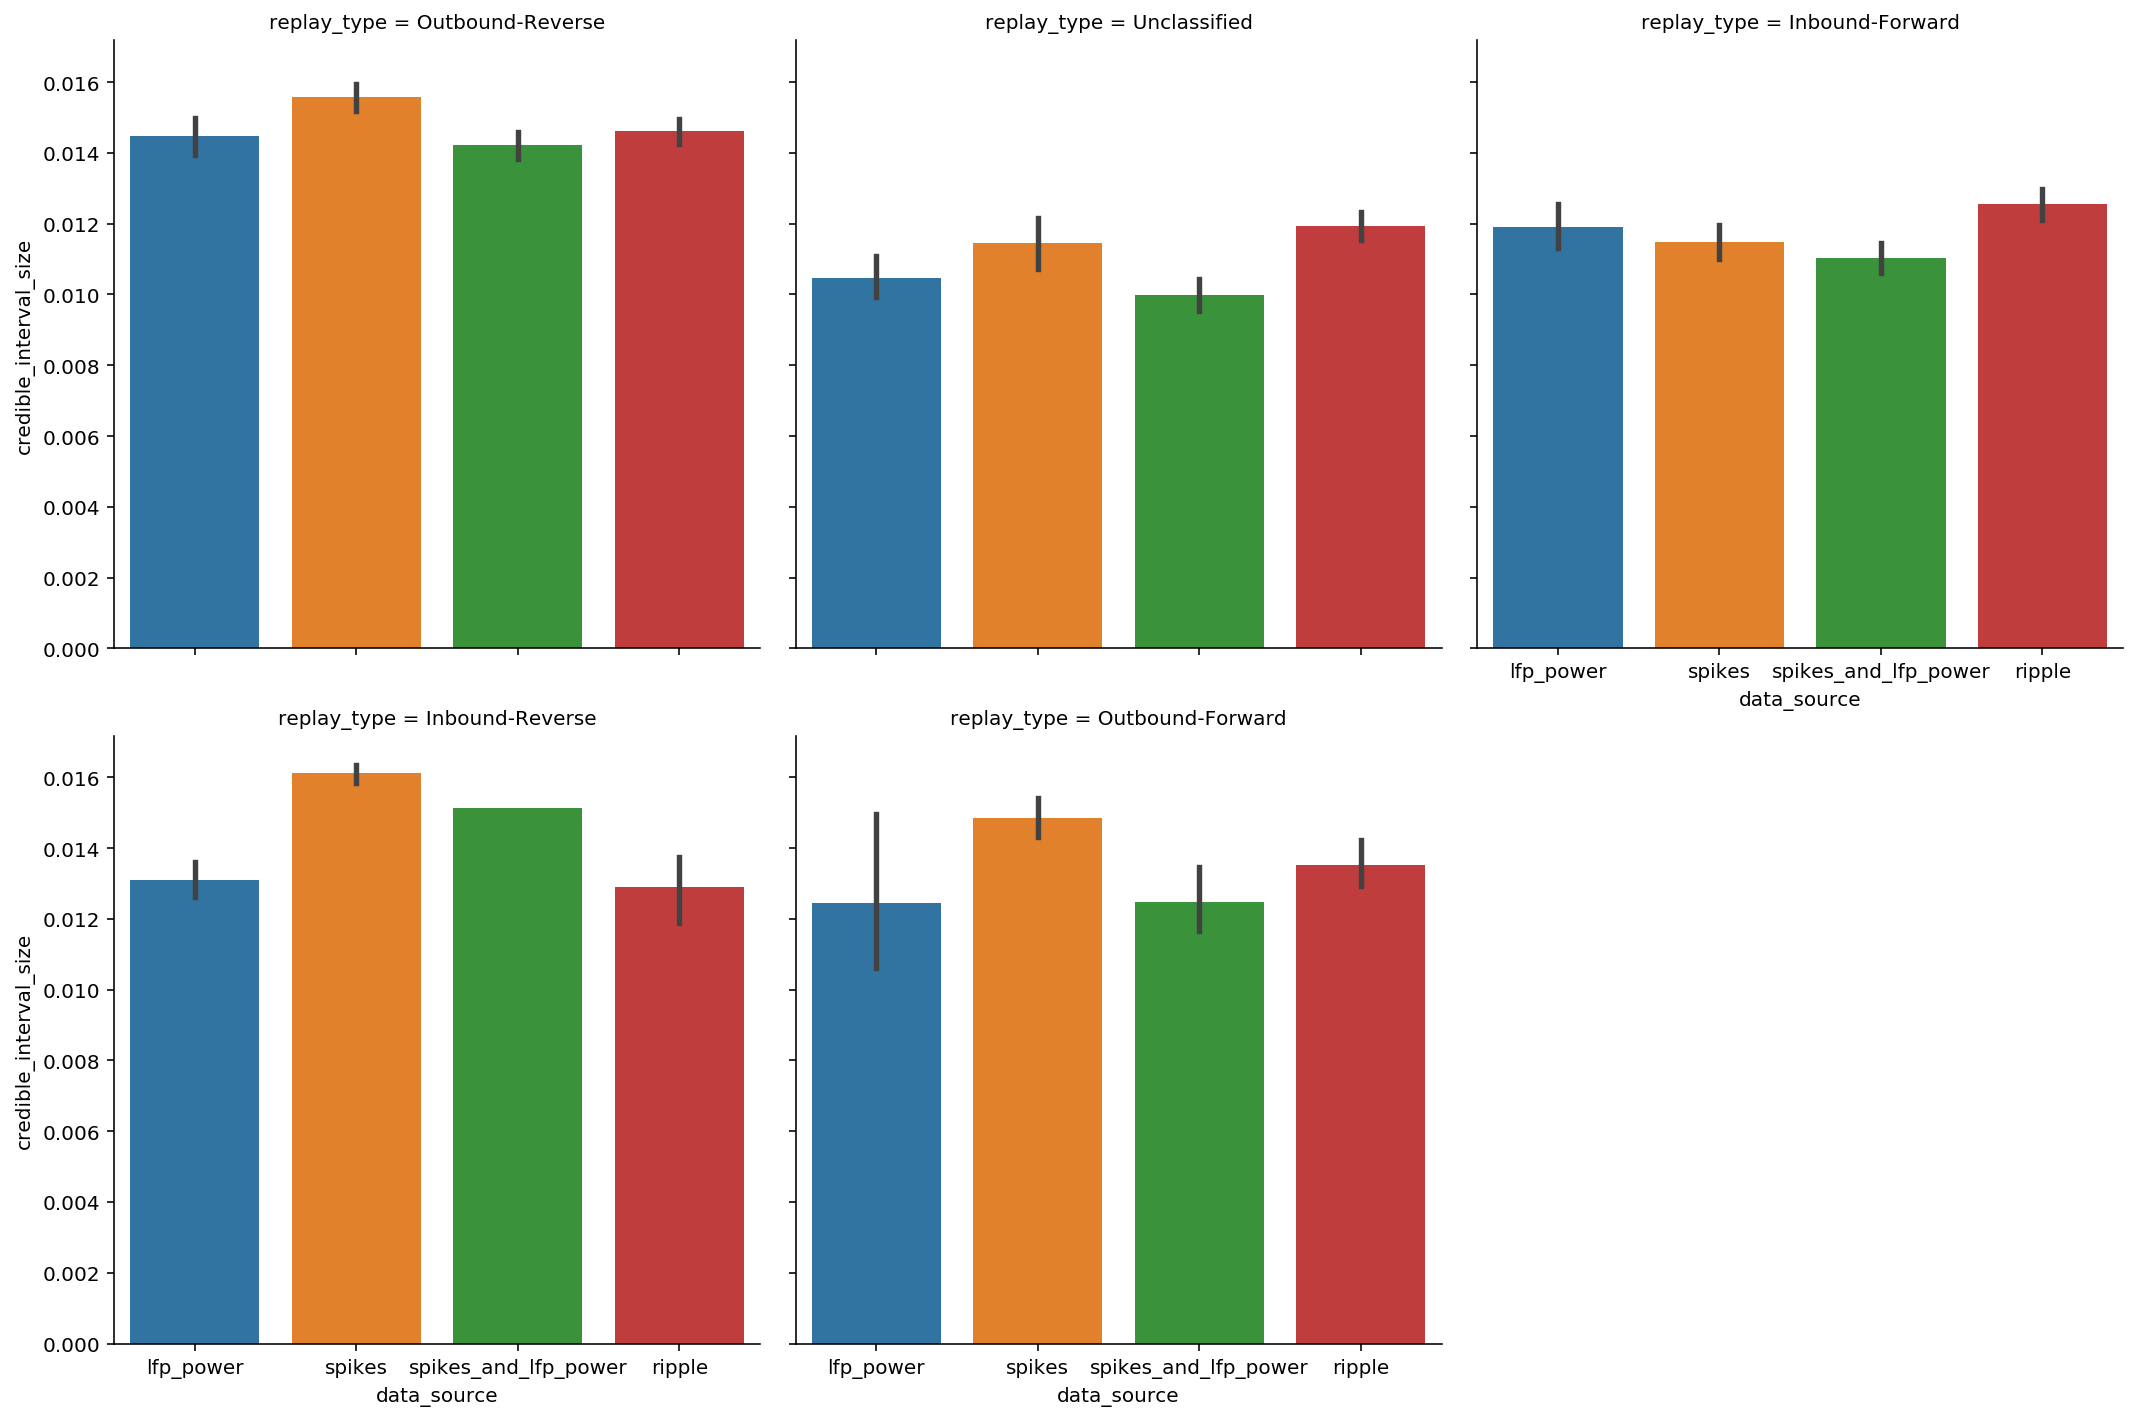

In [204]:
# Compare width of the posterior confidence bounds
# Compare how far the replay position moves.
sns.catplot(x='data_source', y='credible_interval_size', data=replay_info, aspect=1,
            kind='bar')
sns.catplot(x='data_source', y='credible_interval_size', data=replay_info, aspect=1,
            kind='violin', bw=.15, cut=0)
sns.catplot(x='data_source', y='credible_interval_size', data=replay_info, aspect=1,
            kind='bar', col='replay_type', col_wrap=3)

In [226]:
sns.catplot(x='data_source', y='duration', data=replay_info, aspect=1,
            kind='bar')

TypeError: float() argument must be a string or a number, not 'Timedelta'

In [4]:
import itertools
import sys
from os.path import join

import xarray as xr

from src.parameters import PROCESSED_DATA_DIR, USE_LIKELIHOODS

filenames = join(PROCESSED_DATA_DIR, '*.nc')

names = list(USE_LIKELIHOODS.keys())
n_data_sources = len(USE_LIKELIHOODS)
names_ind = np.arange(n_data_sources)
confusion_matrix = np.eye(n_data_sources) * 0.5
start_time_difference = np.zeros((n_data_sources, n_data_sources))
end_time_difference = np.zeros((n_data_sources, n_data_sources))

combination = itertools.combinations(names, 2)
combination_ind = itertools.combinations(names_ind, 2)
overlap_info = []

for (name1, name2), (ind1, ind2) in zip(combination, combination_ind):
    df = xr.open_mfdataset(
        filenames, group=f'/overlap/{name1}/{name2}', autoclose=True
    ).to_dataframe()
    df['data_source1'] = name1
    df['data_source2'] = name2
    overlap_info.append(df)

overlap_info = pd.concat(overlap_info)

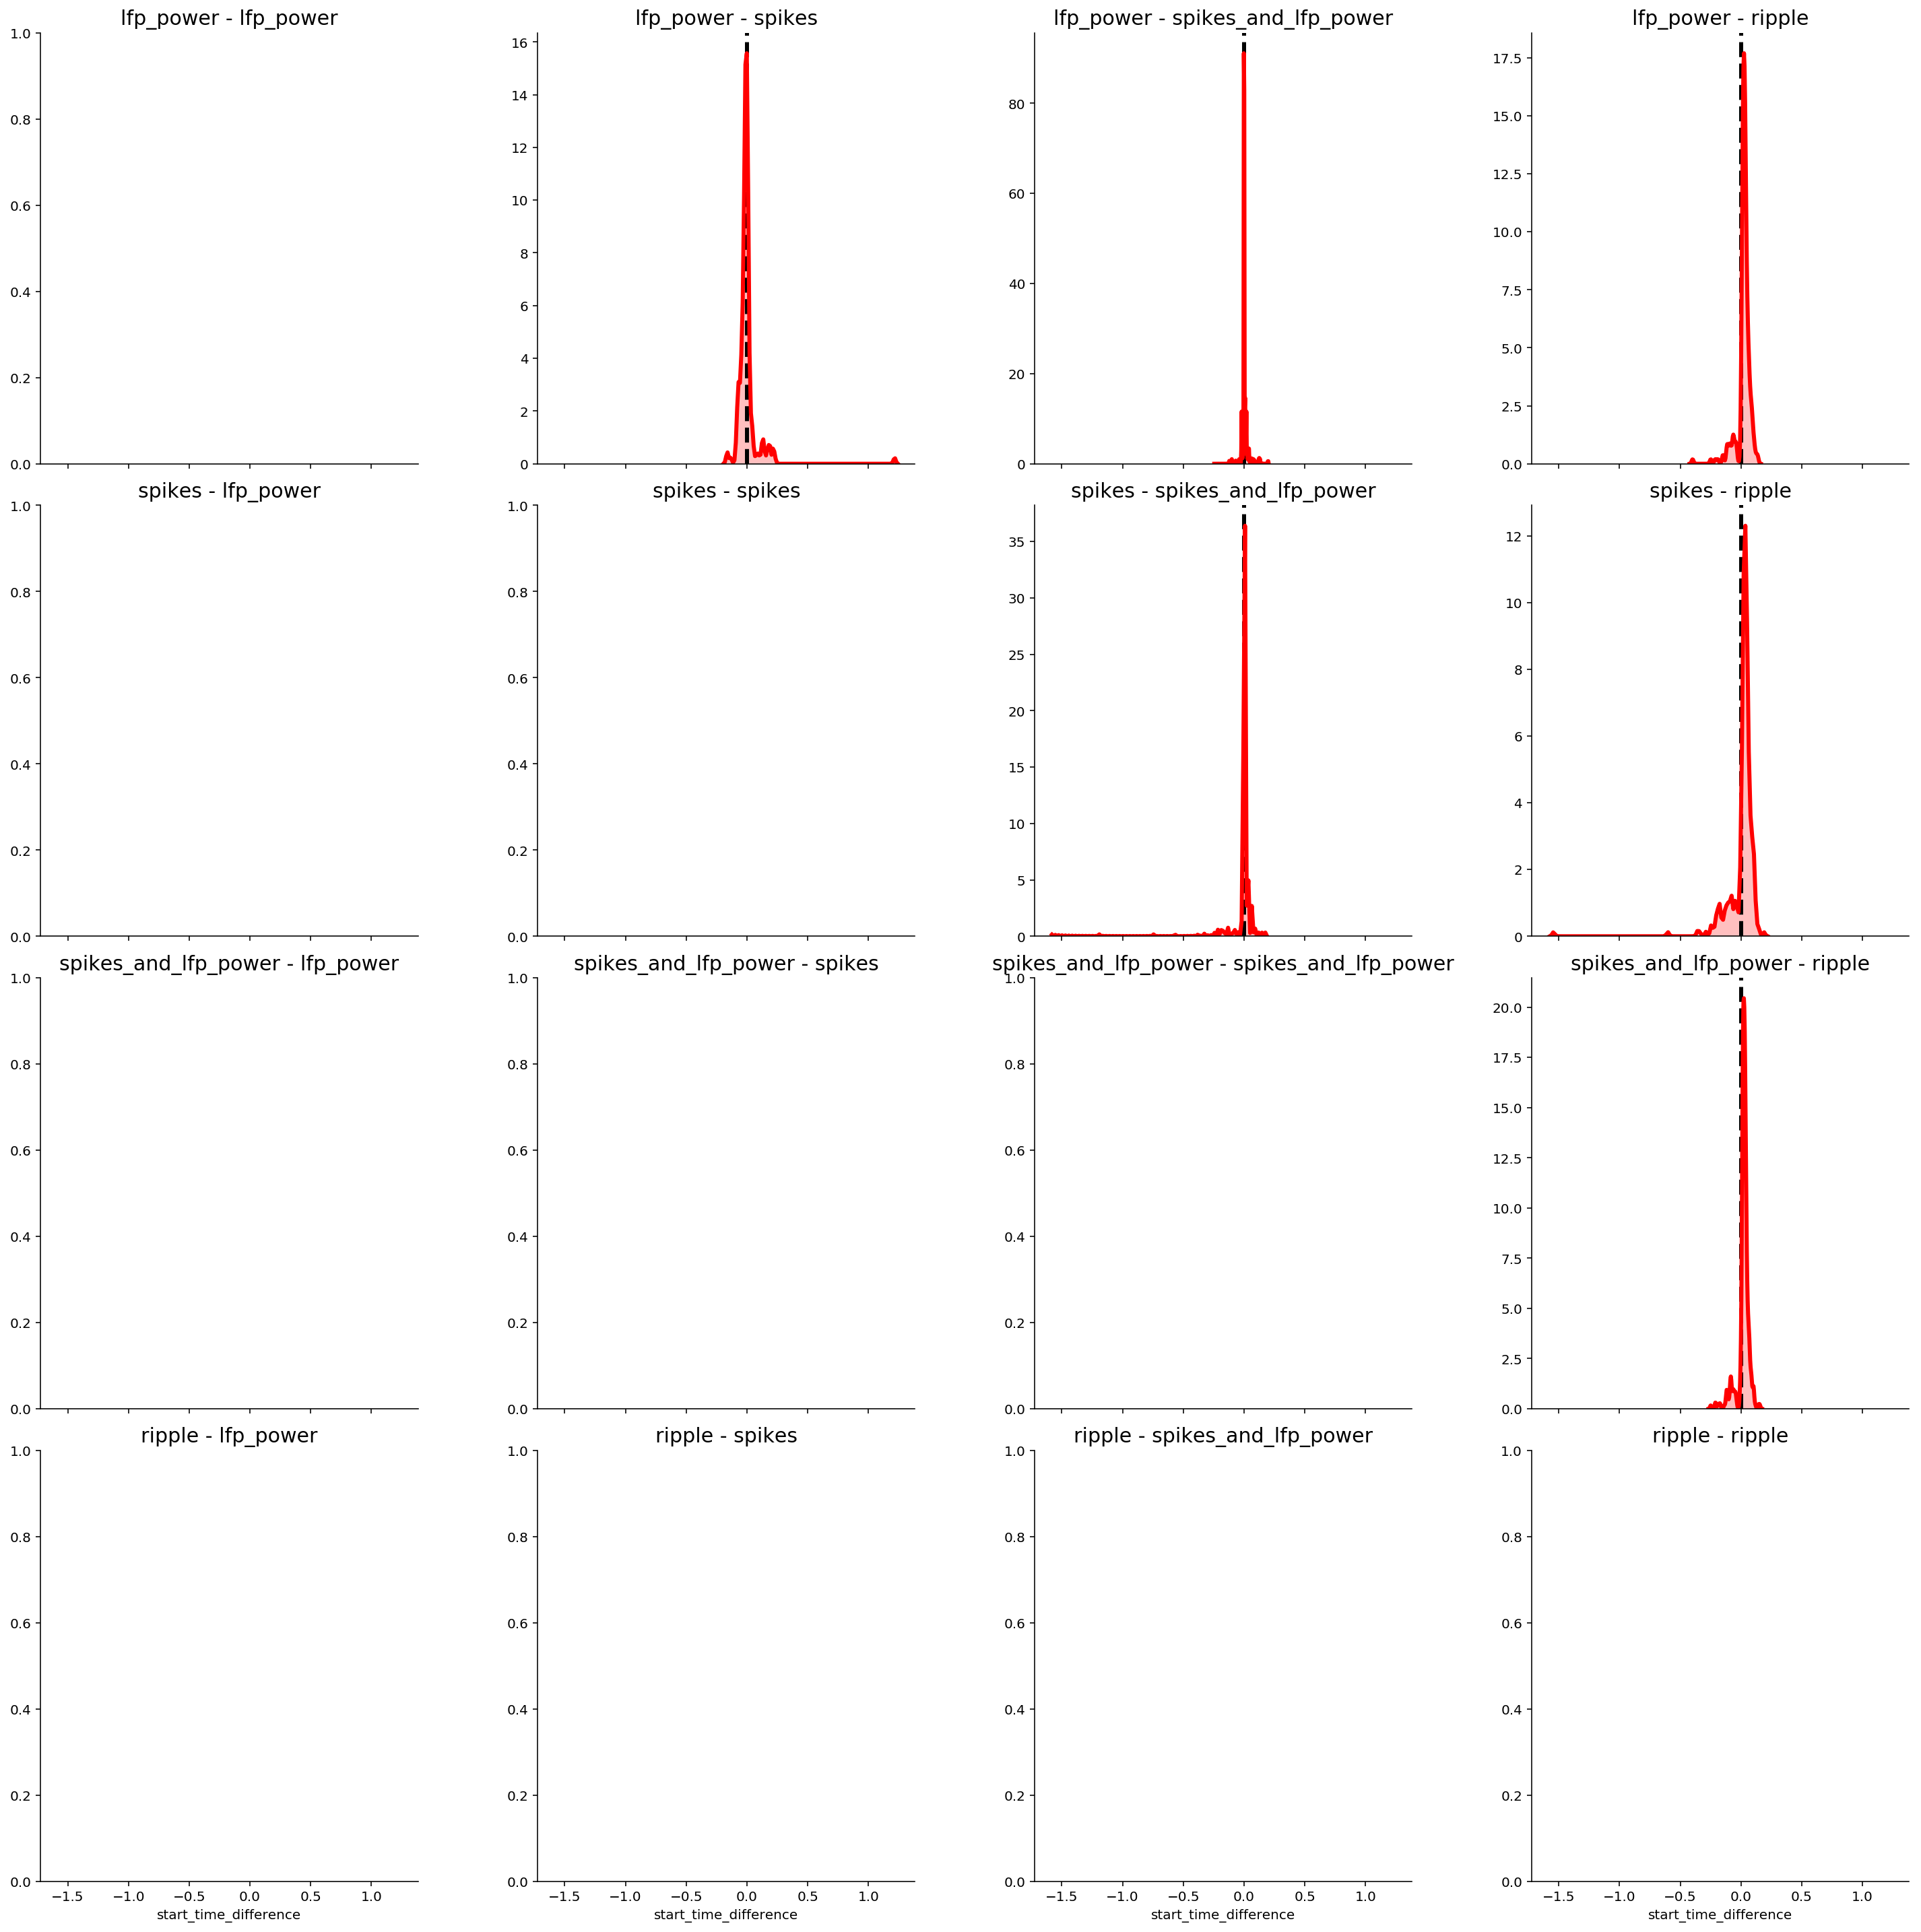

In [231]:
import seaborn as sns
g = sns.FacetGrid(data=overlap_info,  row='data_source1', col='data_source2', height=5, aspect=1,
                  row_order=names, col_order=names, sharey=False)
g.map(plt.axvline, x=0, color="k", linestyle="--", linewidth=3);
g.map(sns.distplot, "start_time_difference", hist=False, rug=False,
      kde_kws={"color": "red", "lw": 3, 'shade': True}).set_titles("{row_name} - {col_name}", size=15);

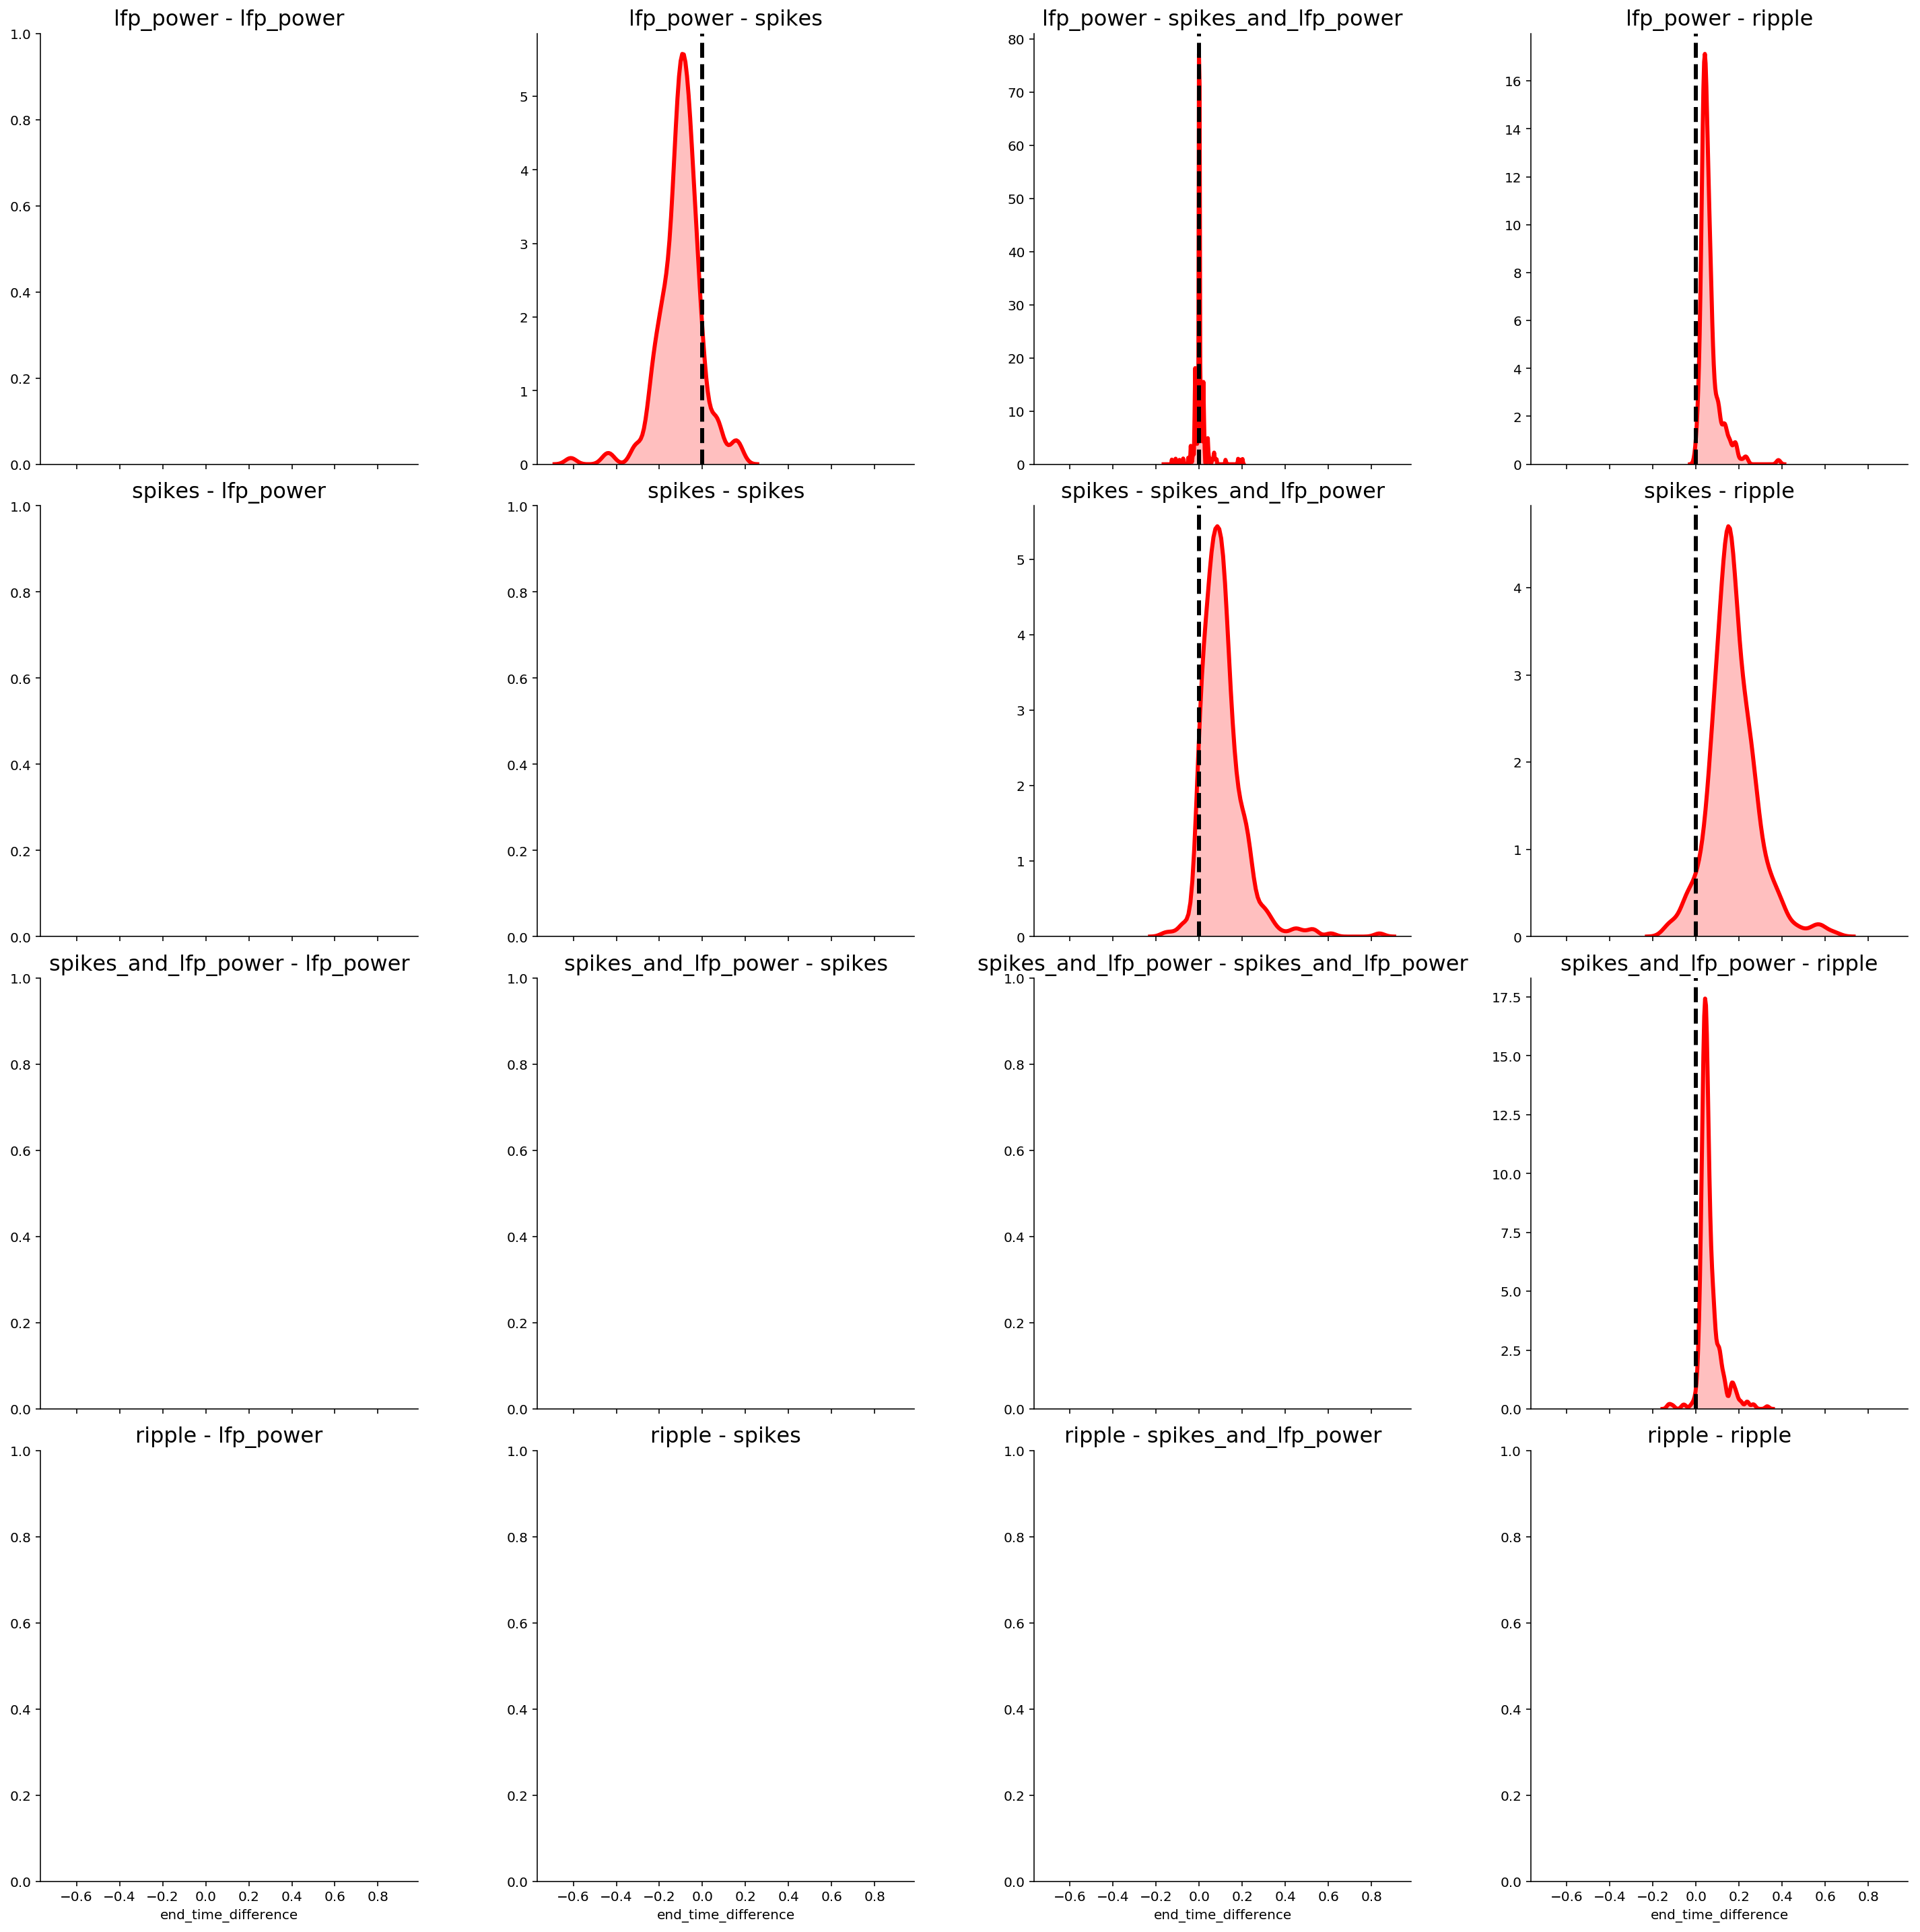

In [232]:
g = sns.FacetGrid(data=overlap_info,  row='data_source1', col='data_source2', height=5, aspect=1,
                  row_order=names, col_order=names, sharey=False)
g.map(plt.axvline, x=0, color="k", linestyle="--", linewidth=3, zorder=100)
g.map(sns.distplot, "end_time_difference", hist=False, rug=False,
      kde_kws={"color": "red", "lw": 3, 'shade': True}).set_titles("{row_name} - {col_name}", size=16);


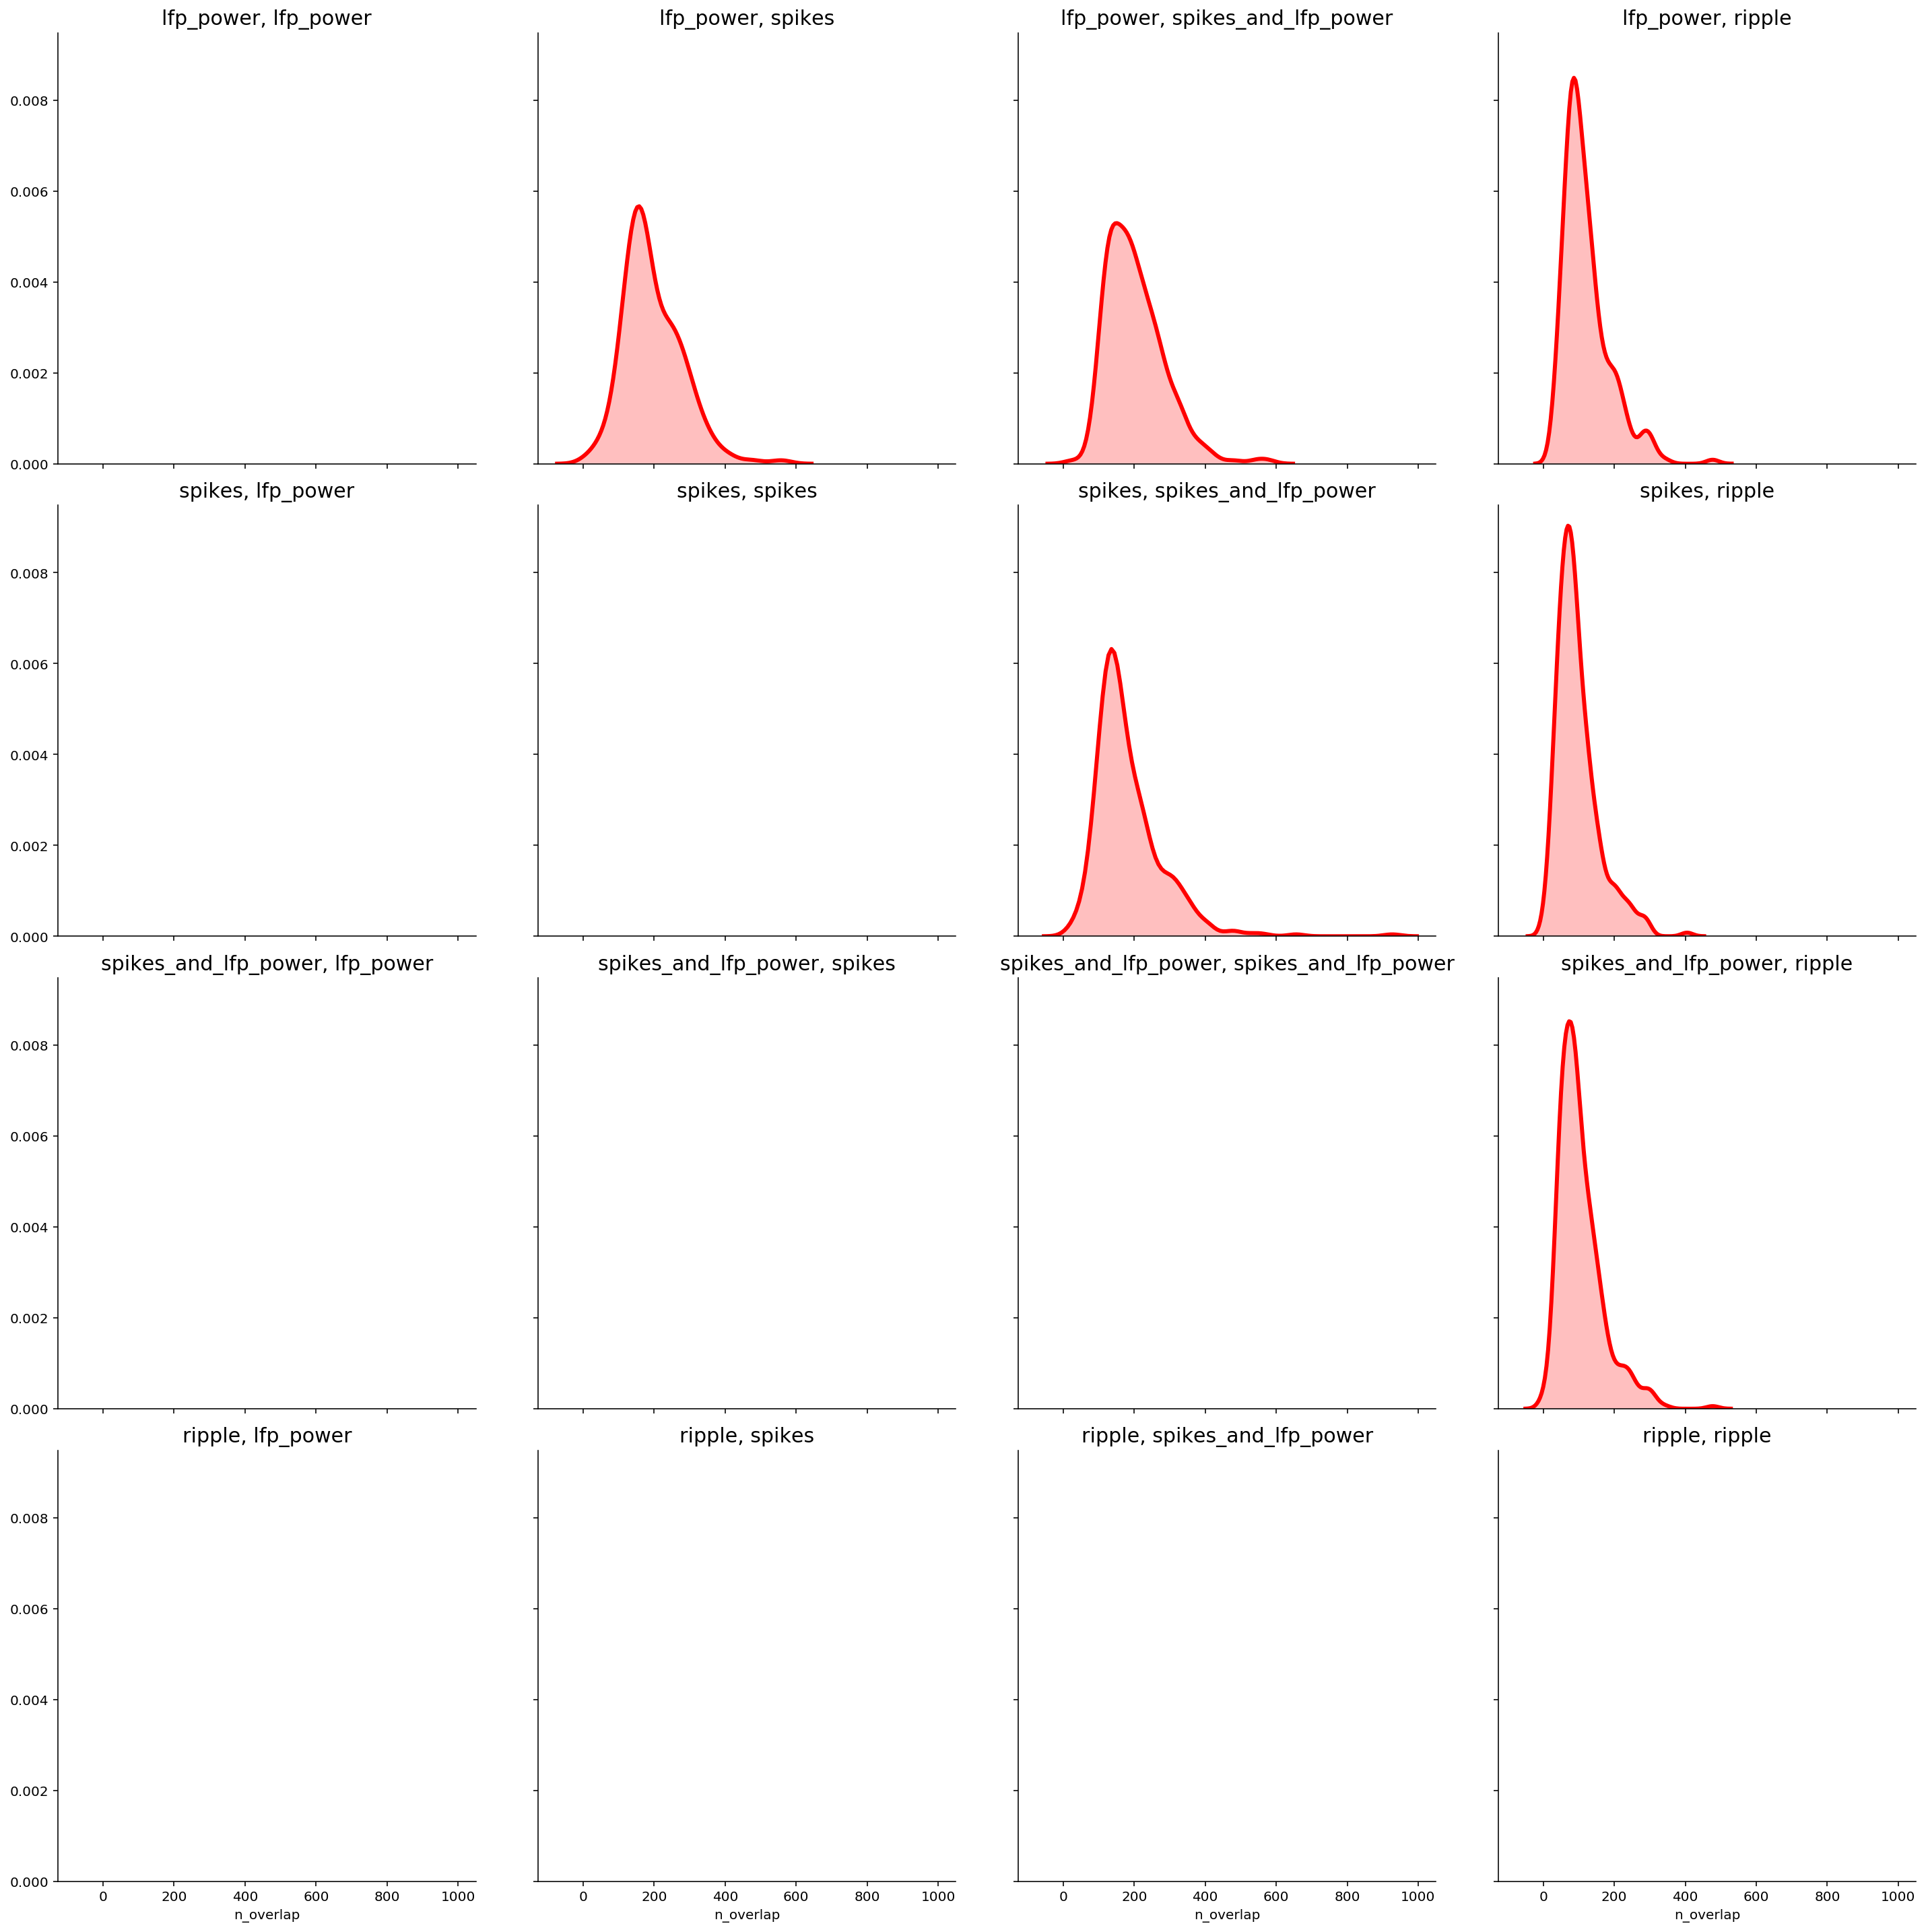

In [224]:
g = sns.FacetGrid(data=overlap_info,  row='data_source1', col='data_source2', height=5, aspect=1,
                  row_order=names, col_order=names)
g.map(sns.distplot, "n_overlap", hist=False, rug=False,
      kde_kws={"color": "red", "lw": 3, 'shade': True}).set_titles("{row_name}, {col_name}", size=15);


In [99]:
overlap_info = overlap_info.assign(jaccard=overlap_info.n_overlap /
           (overlap_info.total_labels1 + overlap_info.total_labels2 - overlap_info.n_overlap))

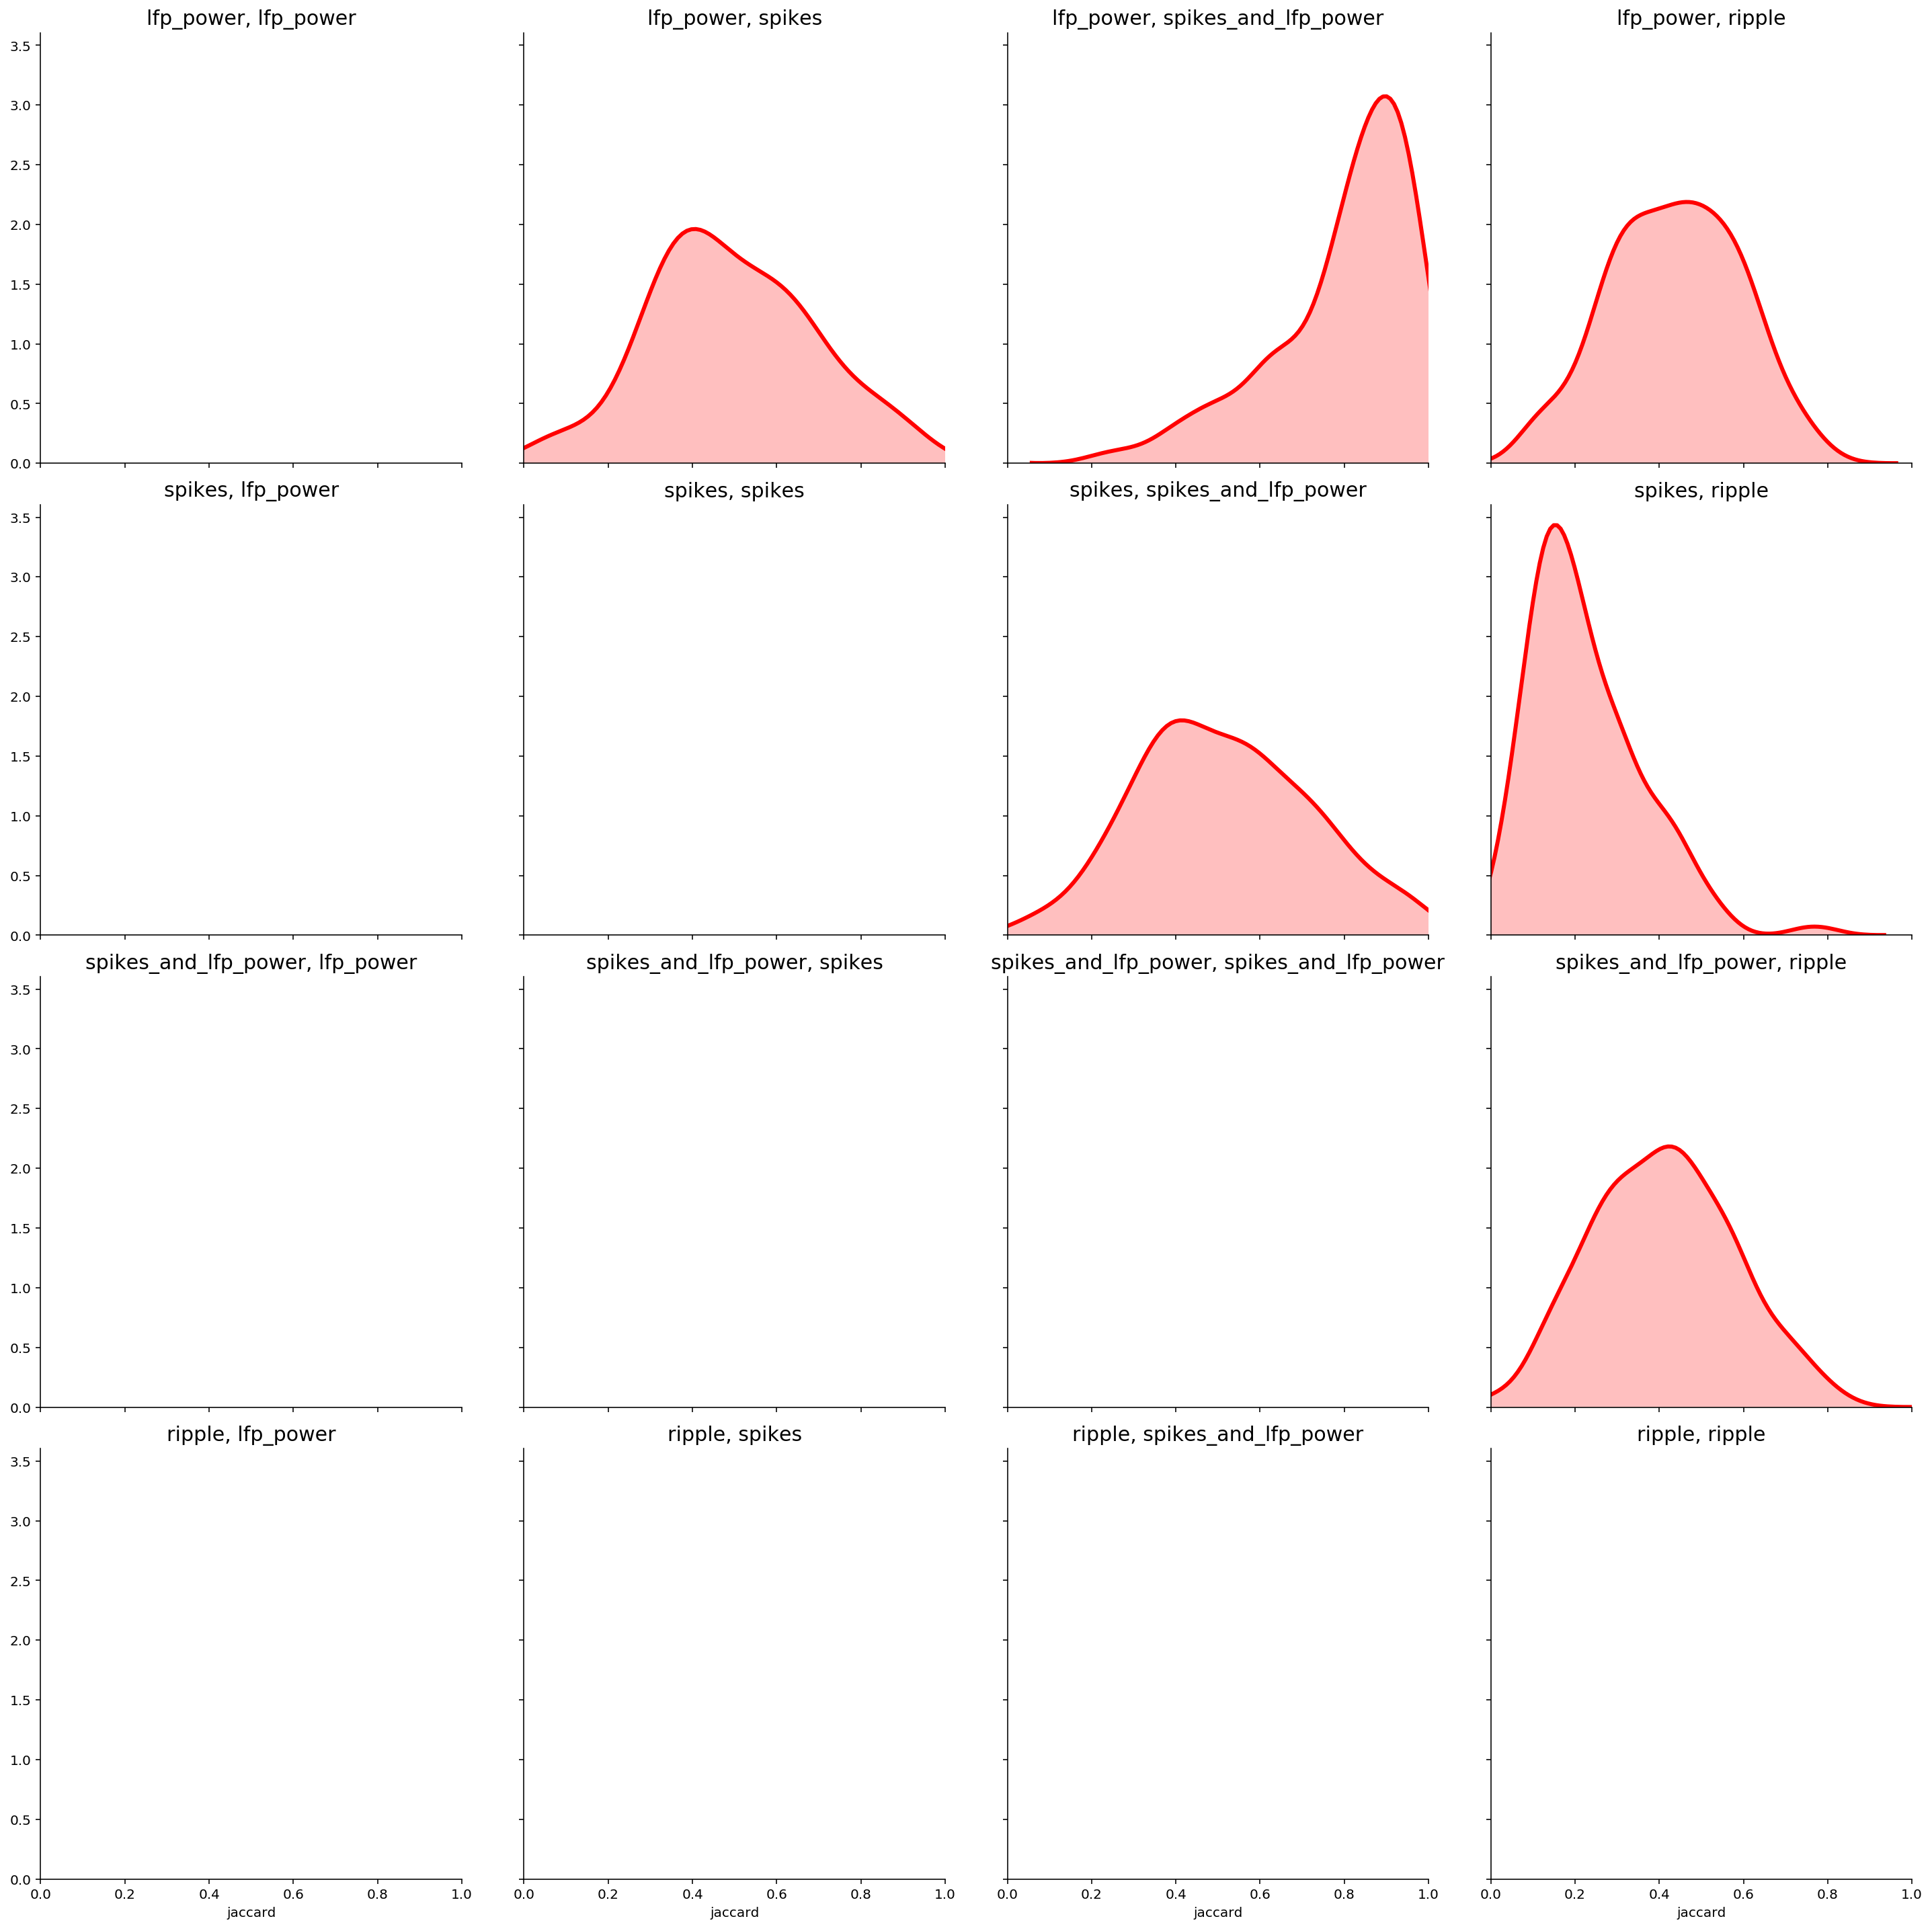

In [233]:
g = sns.FacetGrid(data=overlap_info,  row='data_source1', col='data_source2', height=5, aspect=1,
                  row_order=names, col_order=names)
g.map(sns.distplot, "jaccard", hist=False, rug=False,
      kde_kws={"color": "red", "lw": 3, 'clip': (0, 1), 'shade': True}
     ).set_titles("{row_name}, {col_name}", size=15);
g.set(xlim=(0, 1))

In [209]:

new_index = pd.MultiIndex.from_product((names, names), names=['data_source1', 'data_source2'])
n_overlap = (overlap_info
              .loc[:, ['data_source1', 'data_source2']]
              .groupby(['data_source1', 'data_source2'])
              .agg(len)
              .rename('n_overlap')
              .to_frame()
              .reindex(new_index, fill_value=0.0)
             .sort_index()
            )

n_overlap

n_overlap
data_source1         data_source2                   
lfp_power            lfp_power                   0.0
                     ripple                    252.0
                     spikes                    186.0
                     spikes_and_lfp_power      243.0
ripple               lfp_power                   0.0
                     ripple                      0.0
                     spikes                      0.0
                     spikes_and_lfp_power        0.0
spikes               lfp_power                   0.0
                     ripple                    315.0
                     spikes                      0.0
                     spikes_and_lfp_power      418.0
spikes_and_lfp_power lfp_power                   0.0
                     ripple                    406.0
                     spikes                      0.0
                     spikes_and_lfp_power        0.0

In [340]:
n_overlap = (overlap_info
              .loc[:, ['data_source1', 'data_source2']]
              .groupby(['data_source1', 'data_source2'])
              .agg(len)
              .to_xarray()
              .reindex({'data_source1': names, 'data_source2': names})
            )

n_overlap

<xarray.DataArray (data_source1: 4, data_source2: 4)>
array([[ nan, 186., 243., 252.],
       [ nan,  nan, 418., 315.],
       [ nan,  nan,  nan, 406.],
       [ nan,  nan,  nan,  nan]])
Coordinates:
  * data_source1  (data_source1) <U20 'lfp_power' 'spikes' ... 'ripple'
  * data_source2  (data_source2) <U20 'lfp_power' 'spikes' ... 'ripple'

In [335]:


n_total = replay_info.loc[:, 'data_source'].value_counts().reindex(names)

n_total1 = n_total.copy().rename('n_total1')
n_total1.index = n_total1.index.rename('data_source1')


n_total2 = n_total.copy().rename('n_total2')
n_total2.index = n_total2.index.rename('data_source2')
n_total2

data_source2
lfp_power               249
spikes                  446
spikes_and_lfp_power    540
ripple                  674
Name: n_total2, dtype: int64

In [323]:
n_overlap += n_overlap.T.values + np.eye(len(names)) * n_total.values

In [326]:
jaccard_similarity = n_overlap / (n_total1.to_xarray() + n_total2.to_xarray() - n_overlap)
jaccard_similarity.rename('jaccard_similarity')

<xarray.DataArray 'jaccard_similarity' (data_source1: 4, data_source2: 4)>
array([[1.      , 0.365422, 0.445055, 0.375559],
       [0.365422, 1.      , 0.735915, 0.391304],
       [0.445055, 0.735915, 1.      , 0.502475],
       [0.375559, 0.391304, 0.502475, 1.      ]])
Coordinates:
  * data_source1  (data_source1) <U20 'lfp_power' 'spikes' ... 'ripple'
  * data_source2  (data_source2) <U20 'lfp_power' 'spikes' ... 'ripple'

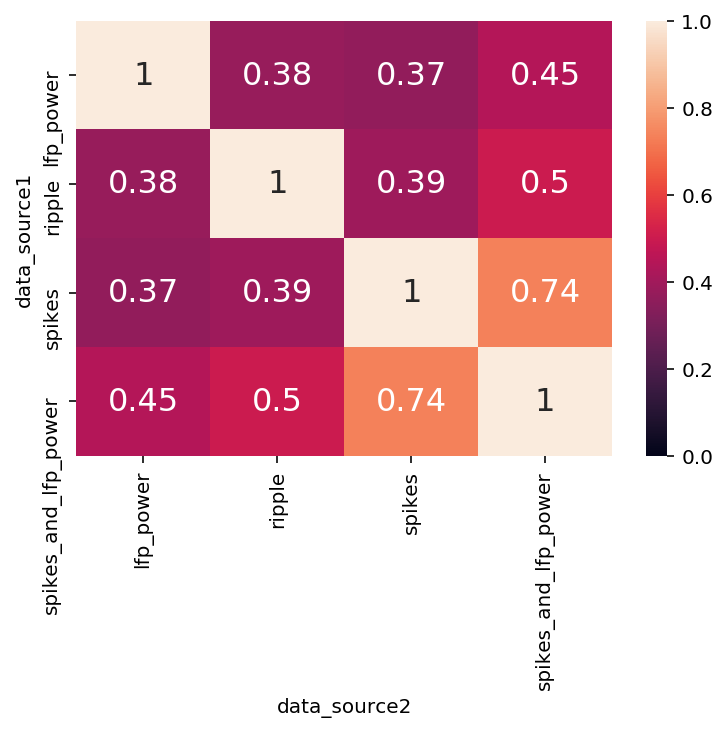

In [357]:
blah = jaccard_similarity.to_dataframe(name='jaccard').unstack()
blah.columns = blah.columns.droplevel(0)
sns.heatmap(blah,
            annot=True, annot_kws={'size': 16}, vmin=0.0, vmax=1.0)

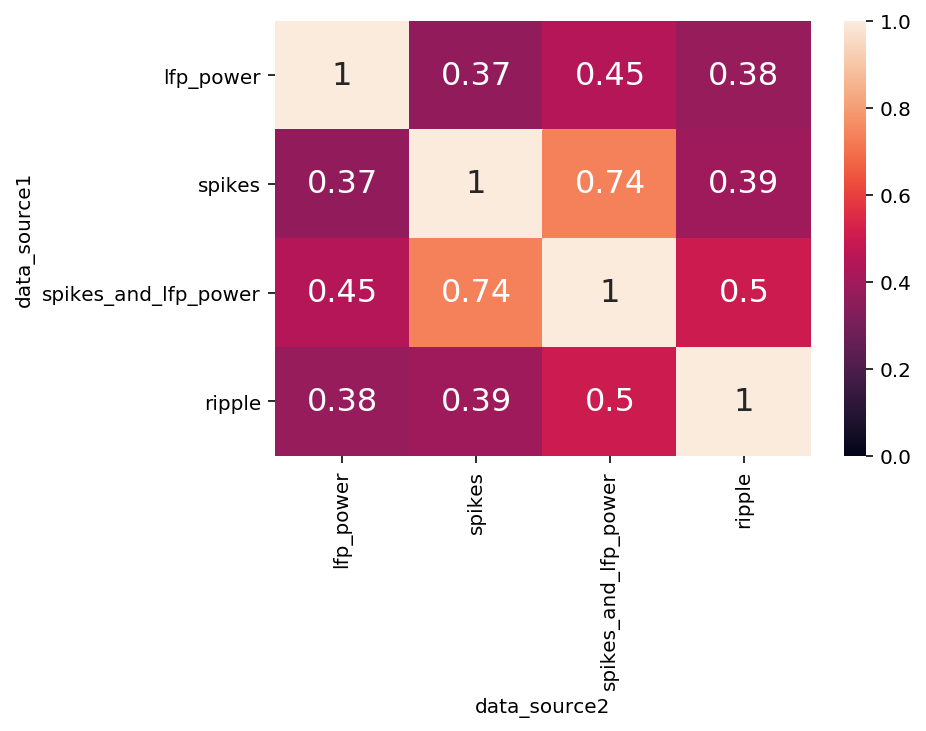

In [361]:
compare_jaccard_similarity_of_replays(overlap_info, replay_info)